In [26]:
from scripts.readers import read_images, read_image
from preprocess.test_filters import give_snr_2d, show_test_filter_sizes_2d

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cc3d
import seaborn as sns
import ipyvolume as p3
import porespy as ps
import networkx as nx
import cv2 as cv
from skimage.io import imread # read in images
from matplotlib.patches import Rectangle
from scipy.ndimage.filters import median_filter, uniform_filter
from sklearn.metrics import roc_curve, auc
from skimage.color import label2rgb, rgb2gray
from skimage.measure import regionprops, label, marching_cubes, regionprops_table
from skimage.segmentation import mark_boundaries, watershed
from skimage.filters import try_all_threshold, threshold_isodata, threshold_otsu, sobel
from skimage.morphology import dilation, opening, disk, closing, erosion, ball, label, skeletonize_3d, binary_opening, binary_dilation
from collections import OrderedDict
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.decomposition  import PCA
from skimage.util            import montage as montage2d
from scipy.ndimage import distance_transform_edt, binary_fill_holes, label, find_objects
from scipy.fftpack import fftn, fftshift
from skimage.feature import peak_local_max, structure_tensor, structure_tensor_eigenvalues
from sklearn.mixture import GaussianMixture
from skimage.transform import rescale
from sklearn.cluster import KMeans
from scipy.stats import ortho_group
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from importlib.metadata import version

In [20]:
img = read_images('/cluster/scratch/spruthi/qbi2024_project/Ru1a/Ru1a_0{0:04}.tif', 750, 1005)
print(img.shape)

  0%|          | 0/256 [00:00<?, ?it/s]

(256, 1517, 1517)


In [21]:
img = img[:,260:771,260:771]

Text(0.5, 1.0, 'Slice Histogram')

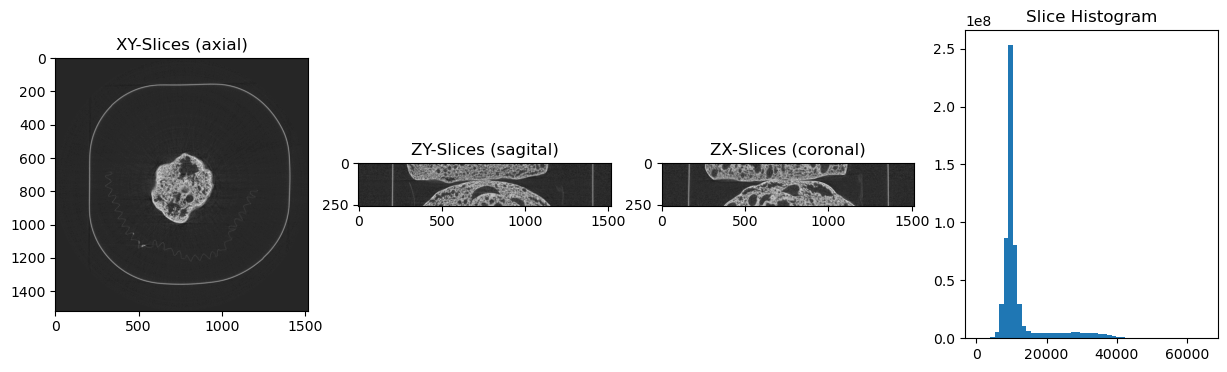

In [3]:
fig, ax = plt.subplots(1,4, figsize = (15, 4))

ax[0].imshow(img[img.shape[0]//2], cmap = 'gray')
ax[0].set_title('XY-Slices (axial)')
ax[1].imshow(img[:,img.shape[1]//2], cmap = 'gray')
ax[1].set_title('ZY-Slices (sagital)')
ax[2].imshow(img[:,:,img.shape[2]//2], cmap = 'gray')
ax[2].set_title('ZX-Slices (coronal)')
_ = ax[3].hist(img.ravel(), bins=51)
ax[3].set_title('Slice Histogram')

In [22]:
img_sample = 5
downsampling_factor = 1

(Text(0.5, 0, 'Image value'), Text(0, 0.5, 'Number of pixels'))

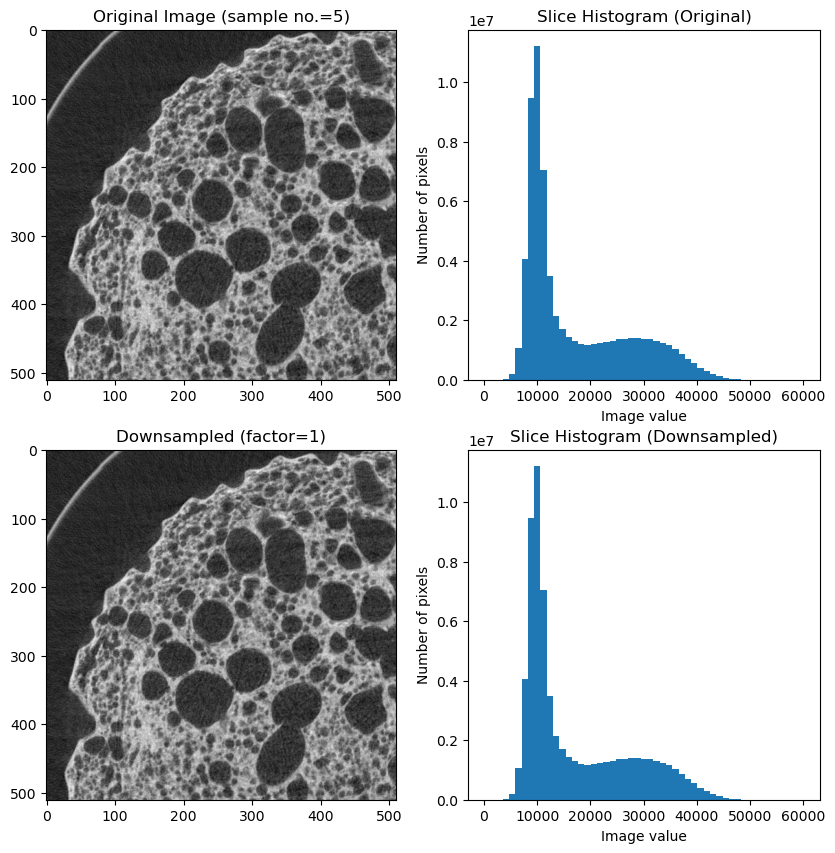

In [23]:
downsample_img = img[:,::downsampling_factor,::downsampling_factor]
#downsample_gray_img = rgb2gray(rgba2rgb(downsample_img))
#plt.imshow(downsample_gray_img[img_sample], cmap = 'gray')

fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].imshow(img[img_sample], cmap = 'gray')
ax[0,0].set_title(f'Original Image (sample no.={img_sample})')
_ = ax[0,1].hist(img.ravel(), bins=51)
ax[0,1].set_title('Slice Histogram (Original)')
ax[0,1].set_xlabel('Image value'), ax[0,1].set_ylabel('Number of pixels')
ax[1,0].imshow(downsample_img[img_sample], cmap = 'gray')
ax[1,0].set_title(f'Downsampled (factor={downsampling_factor})')
_ = ax[1,1].hist(downsample_img.ravel(), bins=51)
ax[1,1].set_title('Slice Histogram (Downsampled)')
ax[1,1].set_xlabel('Image value'), ax[1,1].set_ylabel('Number of pixels')
#ax[1,1].axvline(thresh, color='r')

In [ ]:
ft_image = fftshift(fftn(downsample_img))
power_spectrum = np.abs(ft_image)**2

# Calculate the mean power spectrum along each axis
mean_power_spectrum = [np.mean(power_spectrum, axis=i) for i in range(3)]

# Identify anisotropy by comparing the power spectrum in different directions
anisotropy_ratios = [mean_power_spectrum[i].max() / mean_power_spectrum[i].min() for i in range(3)]

print(f"Anisotropy Ratios: {anisotropy_ratios}")

# Normalize the anisotropy ratios to get the scaling factors
scaling_factors = [1.0 / ratio for ratio in anisotropy_ratios]
print(f"Scaling Factors: {scaling_factors}")

rescaled_image_stack = rescale(downsample_img, scale=scaling_factors, mode='reflect', anti_aliasing=True)

In [7]:
# Calculate the structure tensor of the image stack
A_elems = structure_tensor(downsample_img, sigma=1, order='rc')

# Calculate eigenvalues of the structure tensor
eigenvalues = structure_tensor_eigenvalues(A_elems)

# The eigenvalues can give us an idea of the anisotropy
# We will calculate the average eigenvalues in each direction
mean_eigenvalues = [np.mean(eigenvalues[i]) for i in range(3)]

print(f"Mean eigenvalues: {mean_eigenvalues}")

# Normalize the eigenvalues to get the scaling factors
scaling_factors = [mean_eigenvalues[0] / min(mean_eigenvalues),
                   mean_eigenvalues[1] / min(mean_eigenvalues),
                   mean_eigenvalues[2] / min(mean_eigenvalues)]

print(f"Scaling factors: {scaling_factors}")

rescaled_image_stack = rescale(downsample_img, scale=scaling_factors, mode='reflect', anti_aliasing=True)

Mean eigenvalues: [7085066943.773182, 1291920837.662468, 275165262.97676617]
Scaling factors: [25.748406129197406, 4.695072421883253, 1.0]


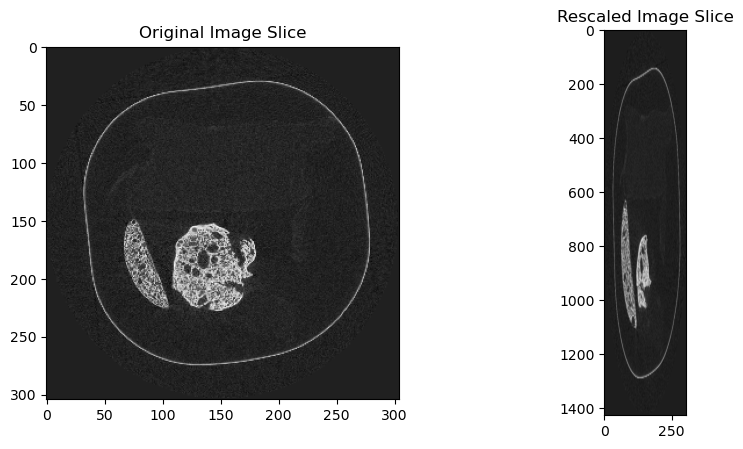

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(downsample_img[img_sample], cmap='gray')
axes[0].set_title('Original Image Slice')
axes[1].imshow(rescaled_image_stack[img_sample], cmap='gray')
axes[1].set_title('Rescaled Image Slice')
plt.show()

In [ ]:
# SNR
a1 = np.array([[1000,1250],[350,500]])
a2 = np.array([[200,250],[70,100]])
fig, ax = plt.subplots(2,2,figsize=(10,10))

img_snr = img[img_sample]
img_ds_snr = downsample_img[img_sample]

ax[0,0].imshow(img_snr, cmap='gray')
ax[0,0].add_patch( Rectangle((a1[0,0], a1[1,0]),
                        a1[0,1]-a1[0,0], a1[1,1]-a1[1,0],
                        fc ='none', 
                        ec ='r',
                        lw = 1) )
# extract a sub image
subA1=img_snr[a1[1,0]:a1[1,1],a1[0,0]:a1[0,1]];
snrA1=np.mean(subA1)/np.std(subA1) # compute the snr
print("SNR for Original Image is {}".format(snrA1))
ax[0,1].imshow(subA1, cmap='gray');

ax[1,0].imshow(img_ds_snr, cmap='gray')
ax[1,0].add_patch( Rectangle((a2[0,0], a2[1,0]),
                        a2[0,1]-a2[0,0], a2[1,1]-a2[1,0],
                        fc ='none', 
                        ec ='r',
                        lw = 1) )
# extract a sub image
subA2=img_ds_snr[a2[1,0]:a2[1,1],a2[0,0]:a2[0,1]];
snrA2=np.mean(subA2)/np.std(subA2) # compute the snr
print("SNR for Downsampled Image is {}".format(snrA2))
ax[1,1].imshow(subA2, cmap='gray');

None


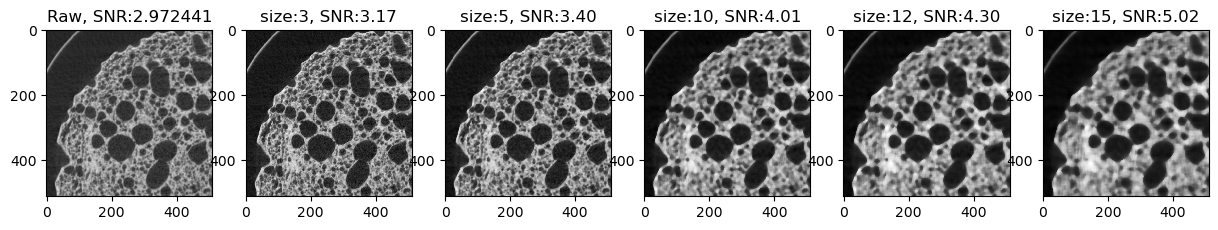

In [27]:
N=[3,5,10,12,15];
a2 = np.array([[200,250],[70,100]])

show_test_filter_sizes_2d(downsample_img[img_sample], N, a2)

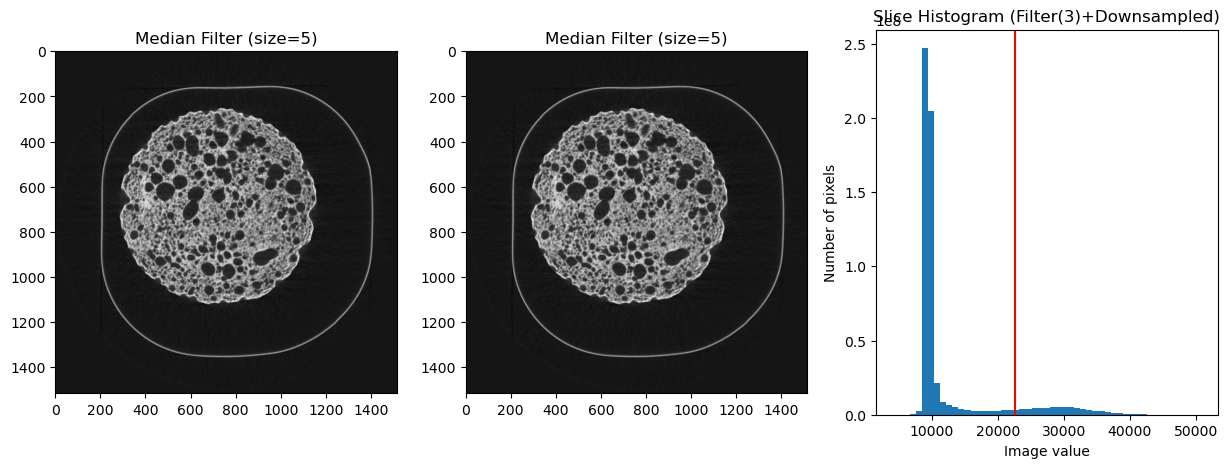

In [6]:
filtersize = 5; thresh = 22500
medfilter3_ds_img = median_filter(downsample_img,filtersize)
#medfilter5_ds_img = median_filter(downsample_img,5)
medfilter5_ds_img = medfilter3_ds_img
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].imshow(medfilter3_ds_img[img_sample], cmap = 'gray')
ax[0].set_title(f'Median Filter (size={filtersize})')
ax[1].imshow(medfilter5_ds_img[img_sample], cmap = 'gray')
ax[1].set_title(f'Median Filter (size=5)')
_ = ax[2].hist(medfilter3_ds_img.ravel(), bins=51)
ax[2].set_title('Slice Histogram (Filter(3)+Downsampled)')
ax[2].set_xlabel('Image value'), ax[2].set_ylabel('Number of pixels')
ax[2].axvline(thresh, color='r')

Text(0.5, 1.0, 'Thresh Filtered(5)+Downsampled Image')

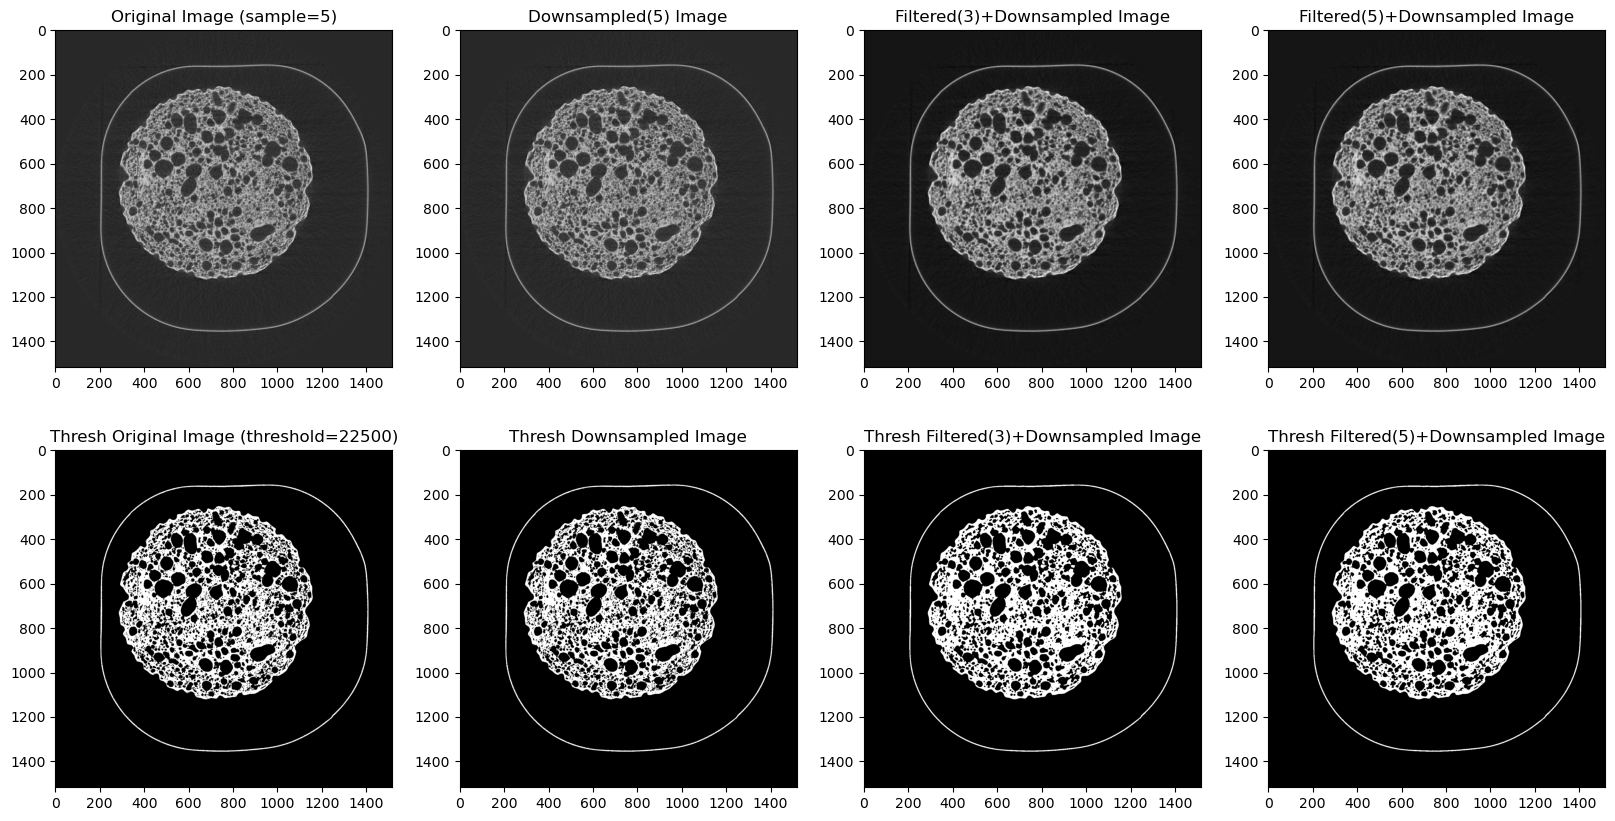

In [7]:
thresh_img = img>thresh
thresh_ds_img = downsample_img>thresh
thresh_filt3ds_img = medfilter3_ds_img>thresh
thresh_filt5ds_img = medfilter5_ds_img>thresh

fig, ax = plt.subplots(2,4, figsize = (20,10))

ax[0,0].imshow(img[img_sample], cmap = 'gray')
ax[0,0].set_title(f'Original Image (sample={img_sample})')

ax[0,1].imshow(downsample_img[img_sample], cmap = 'gray')
ax[0,1].set_title(f'Downsampled(5) Image')

ax[0,2].imshow(medfilter3_ds_img[img_sample], cmap = 'gray')
ax[0,2].set_title(f'Filtered(3)+Downsampled Image')

ax[0,3].imshow(medfilter5_ds_img[img_sample], cmap = 'gray')
ax[0,3].set_title(f'Filtered(5)+Downsampled Image')

ax[1,0].imshow(thresh_img[img_sample], cmap = 'gray')
ax[1,0].set_title(f'Thresh Original Image (threshold={thresh})')
#_ = ax[1,0].hist(thresh_img.ravel(), bins=51)
#ax[1,0].set_title('Slice Histogram')
#ax[1,0].set_xlabel('Image value'), ax[0,1].set_ylabel('Number of pixels')

ax[1,1].imshow(thresh_ds_img[img_sample], cmap = 'gray')
ax[1,1].set_title(f'Thresh Downsampled Image')
# _ = ax[1,1].hist(thresh_ds_img.ravel(), bins=51)
# ax[1,1].set_title('Slice Histogram')
# ax[1,1].set_xlabel('Image value'), ax[1,1].set_ylabel('Number of pixels')

ax[1,2].imshow(thresh_filt3ds_img[img_sample], cmap = 'gray')
ax[1,2].set_title(f'Thresh Filtered(3)+Downsampled Image')

ax[1,3].imshow(thresh_filt5ds_img[img_sample], cmap = 'gray')
ax[1,3].set_title(f'Thresh Filtered(5)+Downsampled Image')
# _ = ax[1,2].hist(thresh_filtds_img.ravel(), bins=51)
# ax[1,2].set_title('Slice Histogram')
# ax[1,2].set_xlabel('Image value'), ax[1,2].set_ylabel('Number of pixels')

Text(0.5, 1.0, 'Thresh Low Filtered(5)+Downsampled Image')

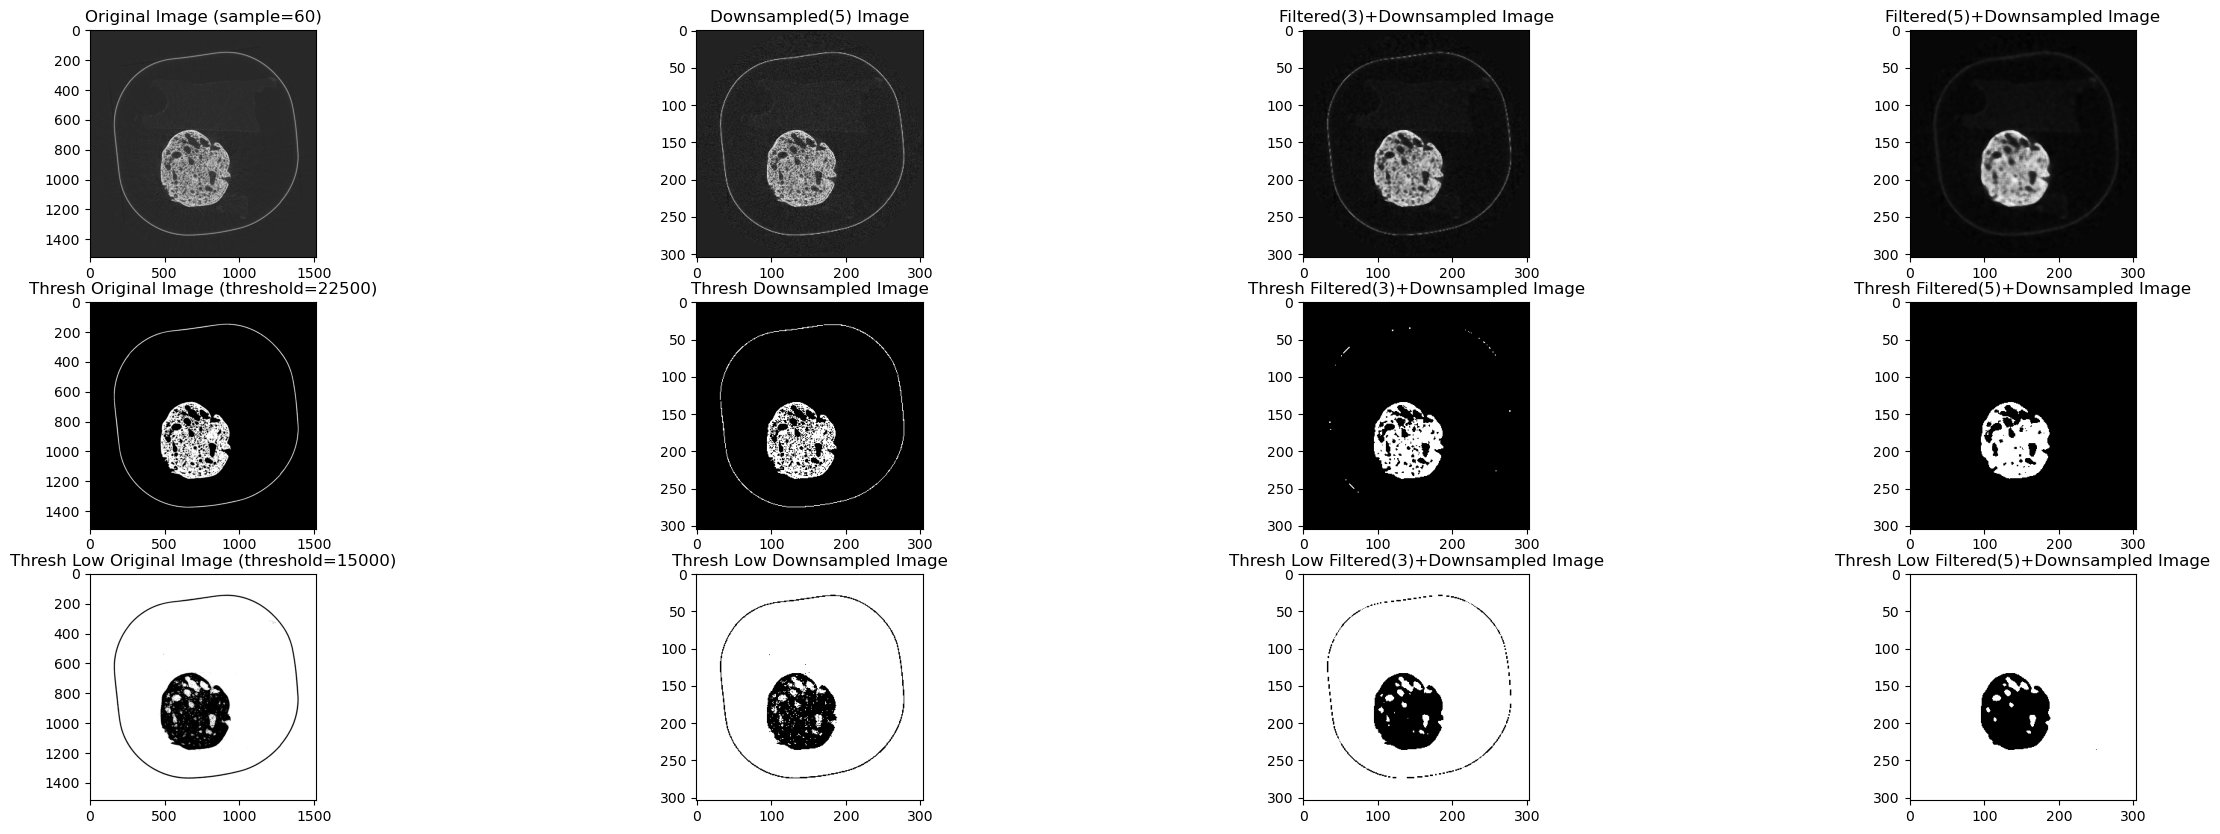

In [22]:
thresh_low = 15000

threshlow_img = img<thresh_low
threshlow_ds_img = downsample_img<thresh_low
threshlow_filt3ds_img = medfilter3_ds_img<thresh_low
threshlow_filt5ds_img = medfilter5_ds_img<thresh_low

fig, ax = plt.subplots(3,4, figsize = (30,10))

ax[0,0].imshow(img[img_sample], cmap = 'gray')
ax[0,0].set_title(f'Original Image (sample={img_sample})')

ax[0,1].imshow(downsample_img[img_sample], cmap = 'gray')
ax[0,1].set_title(f'Downsampled(5) Image')

ax[0,2].imshow(medfilter3_ds_img[img_sample], cmap = 'gray')
ax[0,2].set_title(f'Filtered(3)+Downsampled Image')

ax[0,3].imshow(medfilter5_ds_img[img_sample], cmap = 'gray')
ax[0,3].set_title(f'Filtered(5)+Downsampled Image')

ax[1,0].imshow(thresh_img[img_sample], cmap = 'gray')
ax[1,0].set_title(f'Thresh Original Image (threshold={thresh})')
#_ = ax[1,0].hist(thresh_img.ravel(), bins=51)
#ax[1,0].set_title('Slice Histogram')
#ax[1,0].set_xlabel('Image value'), ax[0,1].set_ylabel('Number of pixels')

ax[1,1].imshow(thresh_ds_img[img_sample], cmap = 'gray')
ax[1,1].set_title(f'Thresh Downsampled Image')
# _ = ax[1,1].hist(thresh_ds_img.ravel(), bins=51)
# ax[1,1].set_title('Slice Histogram')
# ax[1,1].set_xlabel('Image value'), ax[1,1].set_ylabel('Number of pixels')

ax[1,2].imshow(thresh_filt3ds_img[img_sample], cmap = 'gray')
ax[1,2].set_title(f'Thresh Filtered(3)+Downsampled Image')

ax[1,3].imshow(thresh_filt5ds_img[img_sample], cmap = 'gray')
ax[1,3].set_title(f'Thresh Filtered(5)+Downsampled Image')

ax[2,0].imshow(threshlow_img[img_sample], cmap = 'gray')
ax[2,0].set_title(f'Thresh Low Original Image (threshold={thresh_low})')
#_ = ax[1,0].hist(thresh_img.ravel(), bins=51)
#ax[1,0].set_title('Slice Histogram')
#ax[1,0].set_xlabel('Image value'), ax[0,1].set_ylabel('Number of pixels')

ax[2,1].imshow(threshlow_ds_img[img_sample], cmap = 'gray')
ax[2,1].set_title(f'Thresh Low Downsampled Image')
# _ = ax[1,1].hist(thresh_ds_img.ravel(), bins=51)
# ax[1,1].set_title('Slice Histogram')
# ax[1,1].set_xlabel('Image value'), ax[1,1].set_ylabel('Number of pixels')

ax[2,2].imshow(threshlow_filt3ds_img[img_sample], cmap = 'gray')
ax[2,2].set_title(f'Thresh Low Filtered(3)+Downsampled Image')

ax[2,3].imshow(threshlow_filt5ds_img[img_sample], cmap = 'gray')
ax[2,3].set_title(f'Thresh Low Filtered(5)+Downsampled Image')

In [ ]:
fig, ax = try_all_threshold(downsample_img[img_sample], figsize=(7,7), verbose=False);

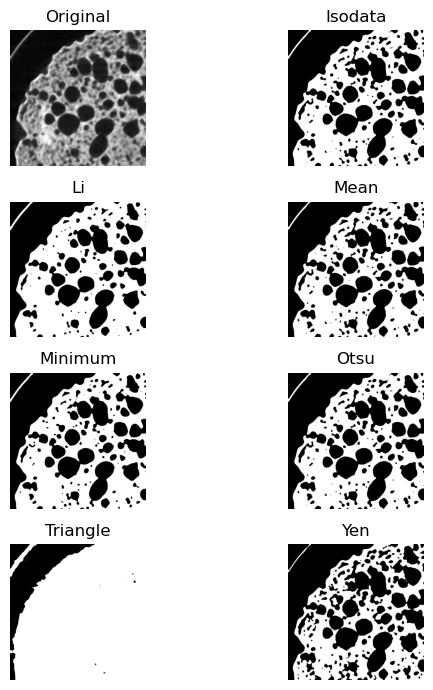

In [16]:
fig, ax = try_all_threshold(medfilter3_ds_img[img_sample], figsize=(7,7), verbose=False);

In [15]:
def goldenCM(N,increment=1.0,s=0.5,v=0.7,bg=0) :
    phi= 0.5*(np.sqrt(5)-1)
    
    hsv = np.zeros([N,3]);
    hsv[:, 0] = increment*phi*np.linspace(0,N-1,N)-np.floor(increment*phi*np.linspace(0,N-1,N))
    hsv[:, 1] = s
    hsv[:, 2] = v
    rgb = hsv2rgb(hsv)
    if bg is not None : rgb[0,:]=bg    
    cm = ListedColormap(rgb) 
    return cm

In [8]:
thresh_otsu = threshold_otsu(medfilter3_ds_img)
thresh_otsu_ds = threshold_otsu(downsample_img)
print(thresh_otsu)
print(thresh_otsu_ds)

19198.004
19839.697


In [17]:
np.ceil(18798.004/500)*500
#round(19698.004/500)*500

19000.0

(-0.5, 1516.5, 1516.5, -0.5)

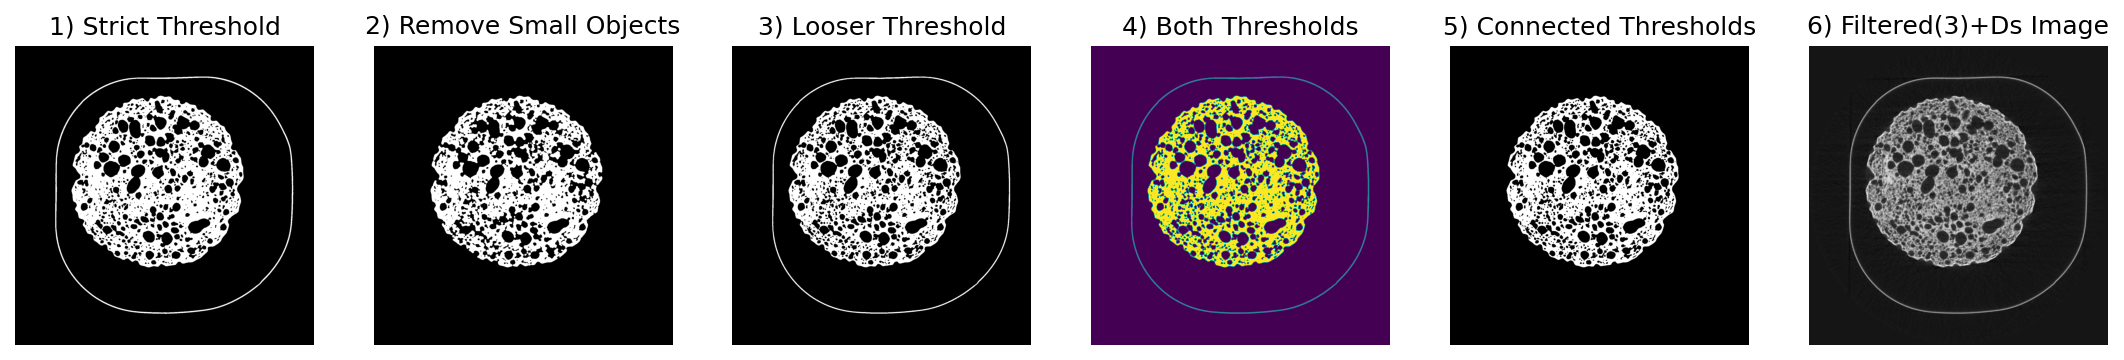

In [10]:
thresh_vals = [0, 18500, 20500] 
step_list = OrderedDict()
step_list['Strict Threshold']     = medfilter3_ds_img>thresh_vals[1]
step_list['Remove Small Objects'] = opening(step_list['Strict Threshold'], ball(5))
step_list['Looser Threshold']     = medfilter3_ds_img>thresh_vals[2]
step_list['Both Thresholds']      = 1.0*step_list['Looser Threshold'] + 1.0*step_list['Remove Small Objects']

# the tricky part keeping the between images
step_list['Connected Thresholds'] = step_list['Remove Small Objects']

for i in range(10):
    step_list['Connected Thresholds'] = dilation(step_list['Connected Thresholds'] , 
                                                 ball(2.5)) & step_list['Looser Threshold']

fig, ax_steps = plt.subplots(1, len(step_list)+1, figsize = (18, 5), dpi = 150)

for i, (c_ax, (c_title, c_img)) in enumerate(zip(ax_steps.flatten(), step_list.items()),1):
    c_ax.imshow(c_img[img_sample], cmap = 'gray' if c_img.max()<=1 else 'viridis')
    c_ax.set_title('%d) %s' % (i, c_title)); c_ax.axis('off');
    if i==5:
        connthresh_medfilter3_ds_img = c_img
    
ax_steps[5].imshow(medfilter3_ds_img[img_sample], cmap='gray')
ax_steps[5].set_title('%d) %s' % (6, "Filtered(3)+Ds Image")); ax_steps[5].axis('off')

(-0.5, 1516.5, 1516.5, -0.5)

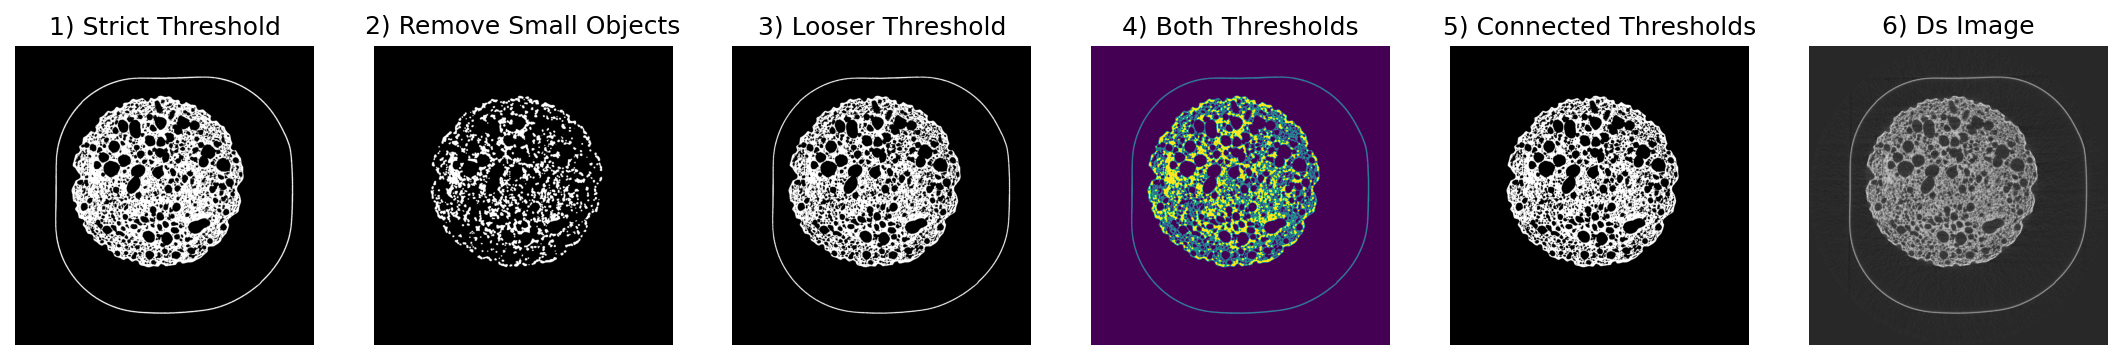

In [11]:
thresh_vals_ds = [0, 19500, 21500] 
step_list_ds = OrderedDict()
step_list_ds['Strict Threshold']     = downsample_img>thresh_vals_ds[1]
step_list_ds['Remove Small Objects'] = opening(step_list_ds['Strict Threshold'], ball(5))
step_list_ds['Looser Threshold']     = downsample_img>thresh_vals_ds[2]
step_list_ds['Both Thresholds']      = 1.0*step_list_ds['Looser Threshold'] + 1.0*step_list_ds['Remove Small Objects']

# the tricky part keeping the between images
step_list_ds['Connected Thresholds'] = step_list_ds['Remove Small Objects']

for i in range(10):
    step_list_ds['Connected Thresholds'] = dilation(step_list_ds['Connected Thresholds'] , 
                                                 ball(2.5)) & step_list_ds['Looser Threshold']

fig, ax_steps = plt.subplots(1, len(step_list_ds)+1, figsize = (18, 5), dpi = 150)

for i, (c_ax, (c_title, c_img)) in enumerate(zip(ax_steps.flatten(), step_list_ds.items()),1):
    c_ax.imshow(c_img[img_sample], cmap = 'gray' if c_img.max()<=1 else 'viridis')
    c_ax.set_title('%d) %s' % (i, c_title)); c_ax.axis('off');
    if i==5:
        connthresh_ds_img = c_img
    
ax_steps[5].imshow(downsample_img[img_sample], cmap='gray')
ax_steps[5].set_title('%d) %s' % (6, "Ds Image")); ax_steps[5].axis('off')

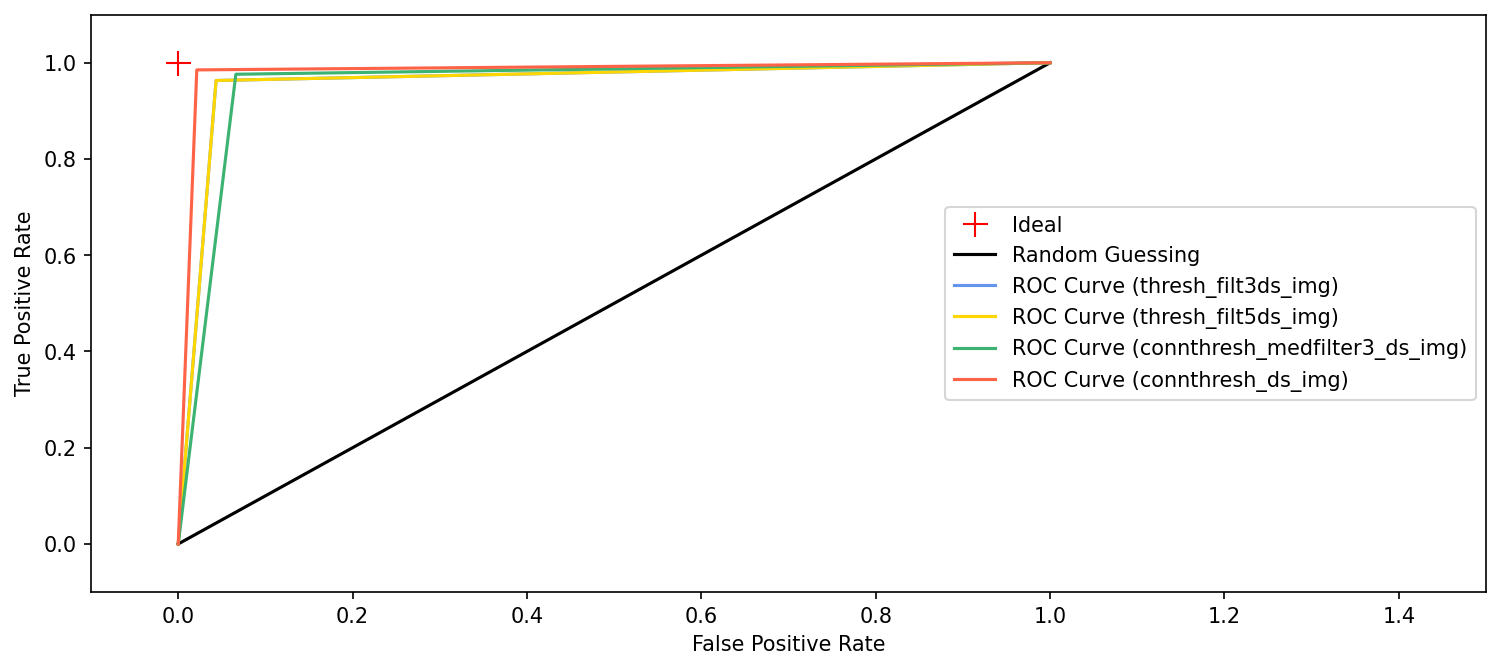

In [13]:
# Not accurate - just to check
fig, ax1 = plt.subplots(1, 1,figsize=(12,5), dpi=150)

ax1.plot(0.0, 1.0, 'r+', markersize=12, label='Ideal')
ax1.plot([0, 1], [0, 1], 'k-', label='Random Guessing')

colors = ['cornflowerblue','gold','mediumseagreen','tomato', 'cyan', 'pink']
for color,c_filt,c_name in zip(colors,[thresh_filt3ds_img, thresh_filt5ds_img, connthresh_medfilter3_ds_img, connthresh_ds_img],['thresh_filt3ds_img', 'thresh_filt5ds_img', 'connthresh_medfilter3_ds_img', 'connthresh_ds_img']):
    fpr, tpr, thresholds = roc_curve(thresh_ds_img.ravel().astype(int), c_filt.ravel())
    ax1.plot(fpr, tpr, '-', markersize=0.01, label='ROC Curve ({})'.format(c_name),color=color)

# Decorations
ax1.set_xlim(-0.1, 1.5); ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('False Positive Rate'); ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="center right", fontsize=10);

In [14]:
# img_thresh_i = np.zeros(img_thresh.shape)
# for i in range(1517):
#     for j in range(1517):
#         if img_thresh[i,j]:
#             img_thresh_i[i,j] = img_nothresh[i,j]
# plt.imshow(img_thresh_i)
lbl_med_ds.max()

12

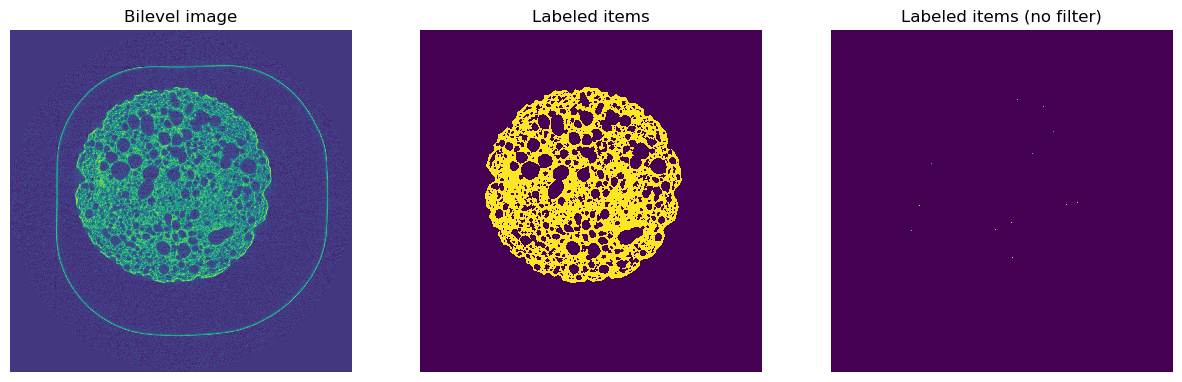

In [12]:
cur_img_sample = img_sample

lbl_med_ds, num_connthresh_medfilter3_ds_img = label(connthresh_medfilter3_ds_img)
lbl_ds, num_connthresh_ds_img = label(connthresh_ds_img)
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(downsample_img[cur_img_sample],interpolation='none'), ax[0].axis('off')
ax[0].set_title('Bilevel image');
ax[1].imshow(lbl_med_ds[cur_img_sample], interpolation='none'),ax[1].axis('off')
ax[1].set_title('Labeled items');
ax[2].imshow(lbl_ds[cur_img_sample],interpolation='none'), ax[2].axis('off')
ax[2].set_title('Labeled items (no filter)');

(Text(0.5, 0, 'Image value'), Text(0, 0.5, 'Number of pixels'))

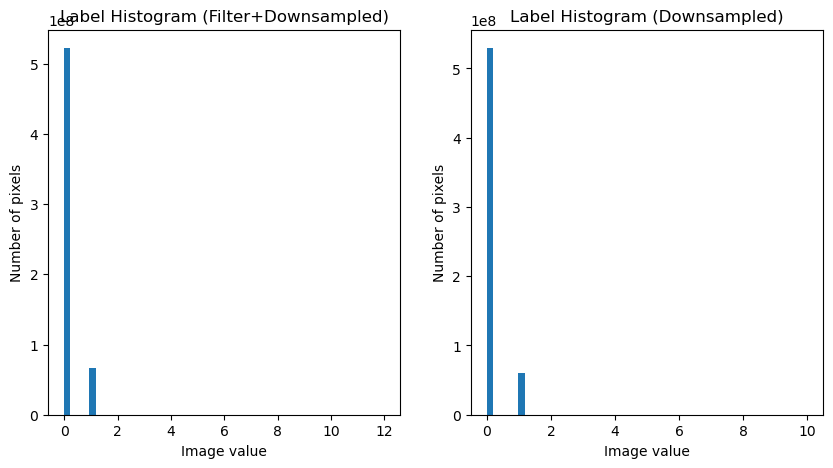

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

_ = ax[0].hist(lbl_med_ds.ravel(), bins=51)
ax[0].set_title('Label Histogram (Filter+Downsampled)')
ax[0].set_xlabel('Image value'), ax[0].set_ylabel('Number of pixels')

_ = ax[1].hist(lbl_ds.ravel(), range=(0,10), bins=51)
ax[1].set_title('Label Histogram (Downsampled)')
ax[1].set_xlabel('Image value'), ax[1].set_ylabel('Number of pixels')
#ax[0].axvline(thresh[1], color='r')
#ax[0].axvline(thresh_vals[2], color='r')

In [16]:
(sum(sum(sum(lbl_med_ds==1)))+sum(sum(sum(lbl_med_ds==0))))/lbl_med_ds.size # 14 and 1
#sum(sum(sum(lbl_med_ds==1)))
#(lbl_med_ds==1).shape
#type(connthresh_medfilter3_ds_img[0,0,0])

0.9999863306906477

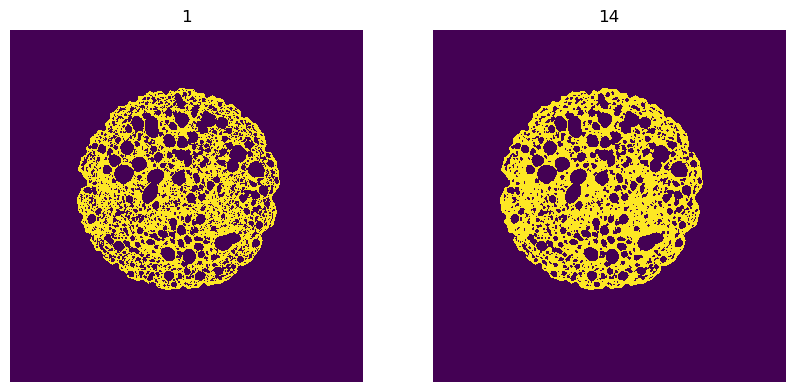

In [17]:
connthresh_medfilter3_ds_img_1 = lbl_ds==1
connthresh_medfilter3_ds_img_14 = lbl_med_ds==1
#print(type(connthresh_medfilter3_ds_img_1[0,0,0]))

cur_img_sample = img_sample

fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(connthresh_medfilter3_ds_img_1[cur_img_sample],interpolation='none'), ax[0].axis('off')
ax[0].set_title('1');
ax[1].imshow(connthresh_medfilter3_ds_img_14[cur_img_sample], interpolation='none'),ax[1].axis('off')
ax[1].set_title('14');

In [ ]:
def show_3d_mesh(image, thresholds, edgecolor='none', alpha=0.5):
    p = image[::-1].swapaxes(1, 2)
    cmap = plt.get_cmap('nipy_spectral_r')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for i, c_threshold in list(enumerate(thresholds)):
        verts, faces, _, _ = marching_cubes(p, c_threshold)
        mesh = Poly3DCollection(verts[faces], alpha=alpha, edgecolor=edgecolor, linewidth=0.1)
        mesh.set_facecolor(cmap(i / len(thresholds))[:3])
        ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0]); ax.set_ylim(0, p.shape[1]); ax.set_zlim(0, p.shape[2])

    ax.view_init(45, 45)
    return fig



show_3d_mesh(connthresh_medfilter3_ds_img, [connthresh_medfilter3_ds_img.mean()],
             alpha=0.75, edgecolor='black');

In [209]:
fig = p3.figure()
# create a custom LUT
temp_tf = plt.cm.nipy_spectral(np.linspace(0, 1, 256))
# make transparency more aggressive
temp_tf[:, 3] = np.linspace(-.3, 0.5, 256).clip(0, 1)
tf = p3.transferfunction.TransferFunction(rgba=temp_tf)
p3.plot_isosurface((connthresh_medfilter3_ds_img/connthresh_medfilter3_ds_img.max()).astype(np.float32), level=0.85)

p3.show()

C:\Users\saksh\miniconda3\envs\qbi2024\lib\site-packages\ipyvolume\pylab.py:957: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  values = skimage.measure.marching_cubes_lewiner(data, level)


Container(children=[HBox(children=(FloatSlider(value=0.85, max=1.0, step=0.004), Button(description='update', …

In [13]:
medfilter3_ds_img_inv = medfilter3_ds_img.max()-medfilter3_ds_img

In [ ]:
thresh_otsu = threshold_otsu(medfilter3_ds_img_inv)
print(thresh_otsu)

In [ ]:
thresh_vals_inv = [0, 20000, 25000] 
step_list_inv = OrderedDict()
step_list_inv['Strict Threshold']     = medfilter3_ds_img_inv>thresh_vals_inv[1]
step_list_inv['Remove Small Objects'] = opening(step_list_inv['Strict Threshold'], ball(1))
step_list_inv['Looser Threshold']     = medfilter3_ds_img_inv>thresh_vals_inv[2]
step_list_inv['Both Thresholds']      = 1.0*step_list_inv['Looser Threshold'] + 1.0*step_list_inv['Remove Small Objects']

# the tricky part keeping the between images
step_list_inv['Connected Thresholds'] = step_list_inv['Remove Small Objects']

for i in range(10):
    step_list_inv['Connected Thresholds'] = dilation(step_list_inv['Connected Thresholds'] , 
                                                 ball(1.8)) & step_list_inv['Looser Threshold']

fig, ax_steps = plt.subplots(1, len(step_list_inv)+1, figsize = (18, 5), dpi = 150)

for i, (c_ax, (c_title, c_img)) in enumerate(zip(ax_steps.flatten(), step_list_inv.items()),1):
    c_ax.imshow(c_img[img_sample], cmap = 'gray' if c_img.max()<=1 else 'viridis')
    c_ax.set_title('%d) %s' % (i, c_title)); c_ax.axis('off');
    if i==5:
        connthresh_medfilter3_ds_img_inv = c_img
    
ax_steps[5].imshow(medfilter3_ds_img_inv[img_sample], cmap='gray')
ax_steps[5].set_title('%d) %s' % (6, "Filtered(3)+Ds Image")); ax_steps[5].axis('off')

In [35]:
ws_medfilter3_ds_img = watershed(medfilter3_ds_img, mask=connthresh_medfilter3_ds_img)
test_img = np.logical_and(medfilter3_ds_img, connthresh_medfilter3_ds_img)
#ws_medfilter3_ds_img = watershed(connthresh_medfilter3_ds_img)

In [18]:
filled_pores_ds = binary_fill_holes(connthresh_ds_img, structure=np.ones((1,2,2)))
test_img_edge_ds = sobel(filled_pores_ds)
inverted_image_ds = np.copy(connthresh_ds_img)
inverted_image_ds[filled_pores_ds] = inverted_image_ds.max() ^ inverted_image_ds[filled_pores_ds]
inv_img_test_ds = inverted_image_ds | (test_img_edge_ds!=0)
#dilated_edges = dilation(test_img_edge, ball(1))

filled_pores_1 = binary_fill_holes(connthresh_medfilter3_ds_img_1, structure=np.ones((1,3,3)))
test_img_edge_1 = sobel(filled_pores_1)
inverted_image_1 = np.copy(connthresh_medfilter3_ds_img_1)
inverted_image_1[filled_pores_1] = inverted_image_1.max() ^ inverted_image_1[filled_pores_1]
inv_img_test_1 = inverted_image_1 | (test_img_edge_1!=0)

filled_pores_14 = binary_fill_holes(connthresh_medfilter3_ds_img_14, structure=np.ones((1,3,3)))
test_img_edge_14 = sobel(filled_pores_14)
inverted_image_14 = np.copy(connthresh_medfilter3_ds_img_14)
inverted_image_14[filled_pores_14] = inverted_image_14.max() ^ inverted_image_14[filled_pores_14]
inv_img_test_14 = inverted_image_14 | (test_img_edge_14!=0)

#pores = filled_pores & connthresh_medfilter3_ds_img
#ws_test_edge = watershed(pores)

Text(0.5, 1.0, 'With Only DS(5)')

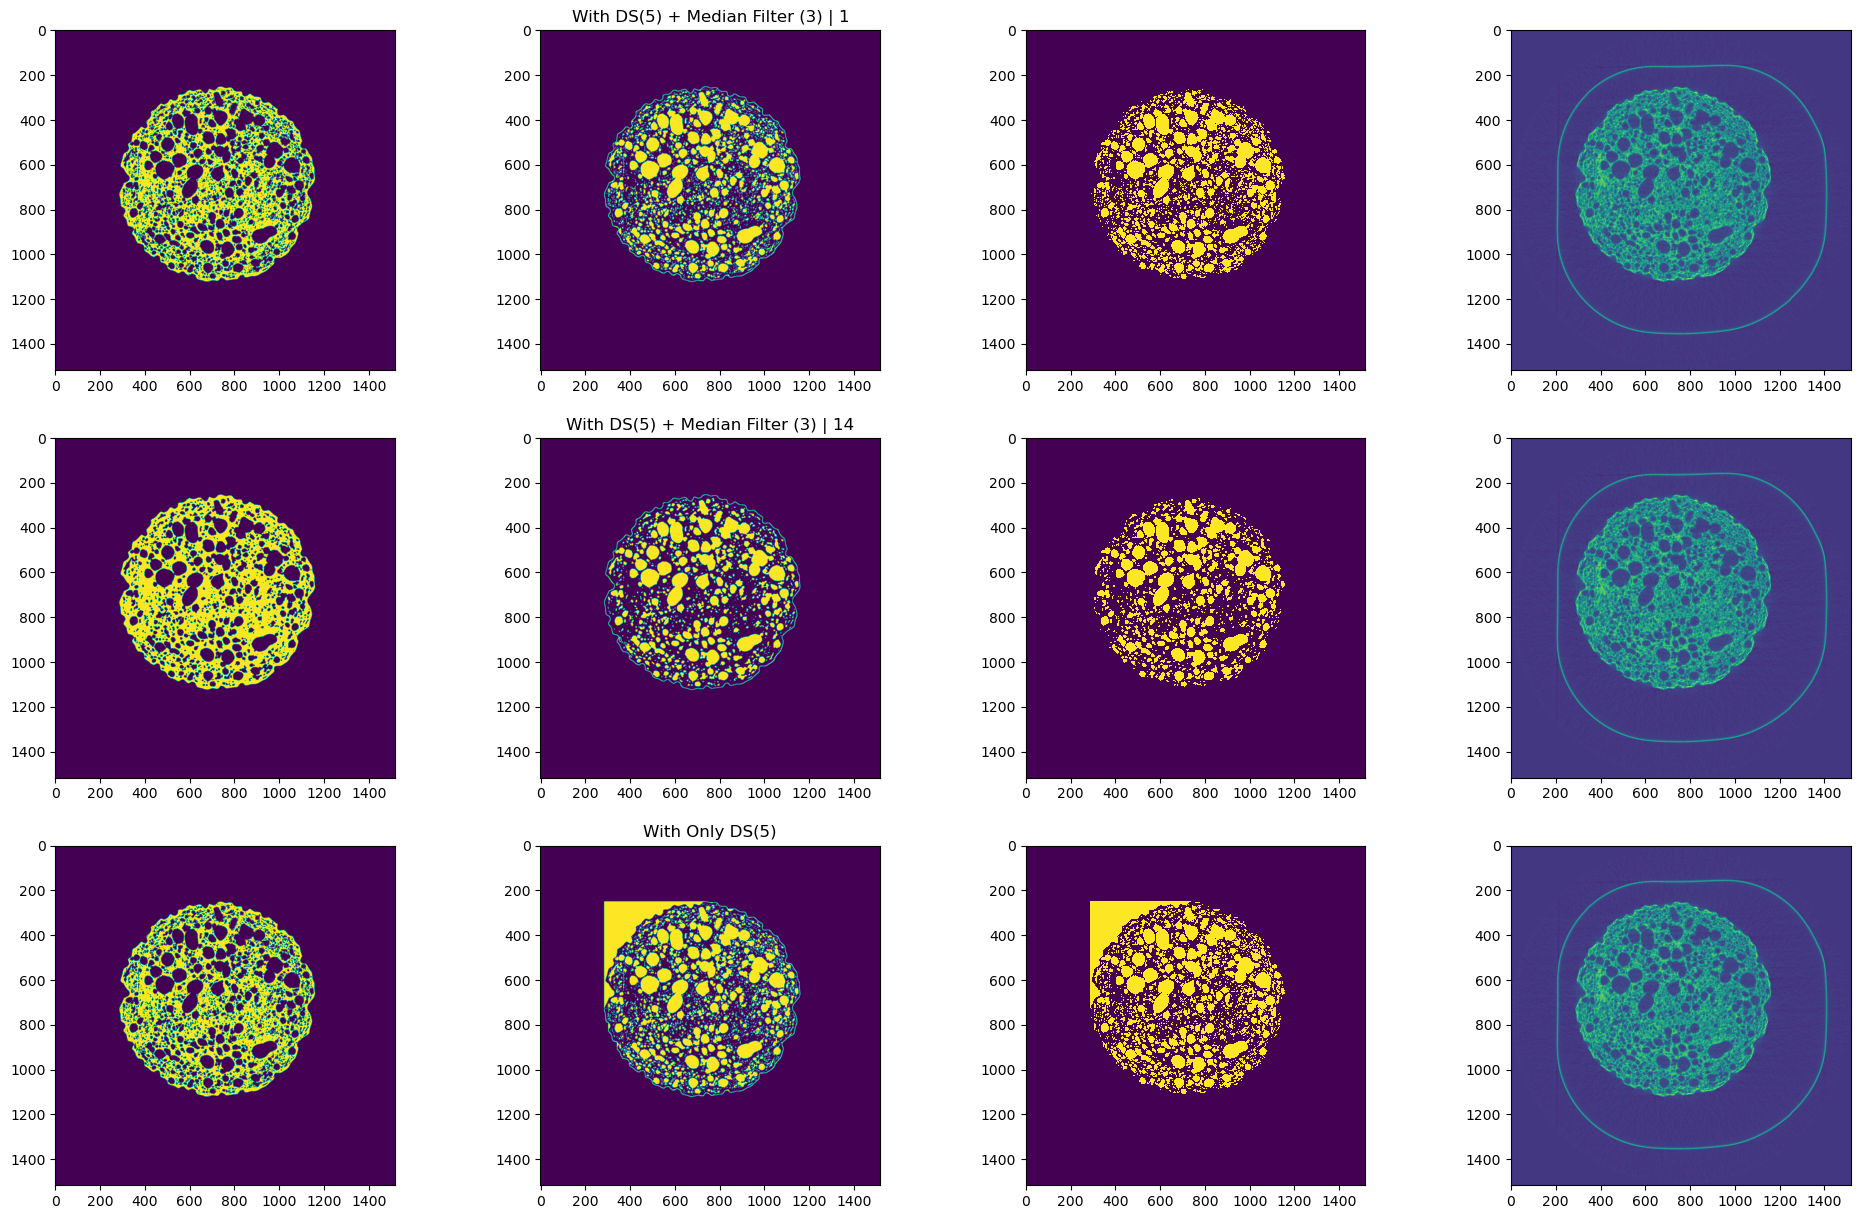

In [21]:
fig, ax = plt.subplots(3,4, figsize=(24,15))
cur_img_sample = img_sample

ax[0,3].imshow(downsample_img[cur_img_sample], cmap='viridis')
ax[0,0].imshow(connthresh_medfilter3_ds_img_1[cur_img_sample], cmap='viridis')
ax[0,1].imshow(inv_img_test_1[cur_img_sample], cmap='viridis')
ax[0,2].imshow(inverted_image_1[cur_img_sample], interpolation='none', cmap='viridis')
ax[0,1].set_title('With DS(5) + Median Filter (3) | 1')

ax[1,3].imshow(downsample_img[cur_img_sample], cmap='viridis')
ax[1,0].imshow(connthresh_medfilter3_ds_img_14[cur_img_sample], cmap='viridis')
ax[1,1].imshow(inv_img_test_14[cur_img_sample], cmap='viridis')
ax[1,2].imshow(inverted_image_14[cur_img_sample], interpolation='none', cmap='viridis')
ax[1,1].set_title('With DS(5) + Median Filter (3) | 14')

ax[2,3].imshow(downsample_img[cur_img_sample], cmap='viridis')
ax[2,0].imshow(connthresh_ds_img[cur_img_sample], cmap='viridis')
ax[2,1].imshow(inv_img_test_ds[cur_img_sample], cmap='viridis')
ax[2,2].imshow(inverted_image_ds[cur_img_sample], interpolation='none', cmap='viridis')
ax[2,1].set_title('With Only DS(5)')
#ax[2].hist((inv_img_test.astype(int)).ravel(), bins=51)
#print((inv_img_test.astype(int)).min())

In [22]:
opened_inverted_image_1 = binary_opening(inverted_image_1)
dilated_inverted_image_1 = binary_dilation(opened_inverted_image_1).astype(int)
dilated_inverted_image_1*=255
dist_transform_opened_1 = distance_transform_edt(opened_inverted_image_1)
sure_fg_1 = (dist_transform_opened_1>(0.1*dist_transform_opened_1.max())).astype(int)
sure_fg_1*=255
unknown_1 = dilated_inverted_image_1 - sure_fg_1
#print(sum(sum(sum(sure_fg_1)))/255)
# print(dilated_inverted_image_1)

label_fg_1, _ = label(sure_fg_1)
label_fg_1+=1
label_fg_1[unknown_1==255] = 0

watershed_fg_1 = watershed(inverted_image_1, markers=label_fg_1)
inverted_image_1_test = np.copy(inverted_image_1)
inverted_image_1_test[watershed_fg_1 == -1] = 255

In [ ]:
opened_inverted_image_14 = binary_opening(inverted_image_14)
dilated_inverted_image_14 = binary_dilation(opened_inverted_image_14).astype(int)
dilated_inverted_image_14*=255
dist_transform_opened_14 = distance_transform_edt(opened_inverted_image_14)
sure_fg_14 = (dist_transform_opened_14>(0.1*dist_transform_opened_14.max())).astype(int)
sure_fg_14*=255
unknown_14 = dilated_inverted_image_14 - sure_fg_14
#print(sum(sum(sum(sure_fg_14)))/255)
# print(dilated_inverted_image_14)

label_fg_14, _ = label(sure_fg_14)
label_fg_14+=1
label_fg_14[unknown_14==255] = 0

watershed_fg_14 = watershed(inverted_image_14, markers=label_fg_14)
inverted_image_14_test = np.copy(inverted_image_14)
inverted_image_14_test[watershed_fg_14 == -1] = 255

In [ ]:
inverted_image_dist_1 = distance_transform_edt(inverted_image_1)
lbl_1, num_1 = label(inverted_image_1)

inverted_image_dist_14 = distance_transform_edt(inverted_image_14)
lbl_14, num_14 = label(inverted_image_14)

In [ ]:
fig, ax = plt.subplots(2,5,figsize=(25,10))
cur_img_sample = img_sample+10

ax[0,0].imshow(dilated_inverted_image_1[cur_img_sample], cmap='gray'); ax[0,0].set_title("sure background")
ax[0,1].imshow(sure_fg_1[cur_img_sample], cmap='gray'); ax[0,1].set_title("sure foreground")
ax[0,2].imshow(unknown_1[cur_img_sample], cmap='gray'); ax[0,2].set_title("unknown")
ax[0,3].imshow(label_fg_1[cur_img_sample], cmap='viridis'); ax[0,3].set_title("label")
ax[0,4].imshow(watershed_fg_1[cur_img_sample], cmap='viridis'); ax[0,4].set_title("watershed")

ax[1,0].imshow(dilated_inverted_image_14[cur_img_sample], cmap='gray'); ax[1,0].set_title("sure background")
ax[1,1].imshow(sure_fg_14[cur_img_sample], cmap='gray'); ax[1,1].set_title("sure foreground")
ax[1,2].imshow(unknown_14[cur_img_sample], cmap='gray'); ax[1,2].set_title("unknown")
ax[1,3].imshow(label_fg_14[cur_img_sample], cmap='viridis'); ax[1,3].set_title("label")
ax[1,4].imshow(watershed_fg_14[cur_img_sample], cmap='viridis'); ax[1,4].set_title("watershed")

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(20,10))
#cur_img_sample = img_sample+100

ax[0,0].imshow(downsample_img[cur_img_sample], cmap='viridis')
ax[0,1].imshow(inverted_image_1[cur_img_sample], cmap='viridis')
ax[0,2].imshow(watershed_fg_1[cur_img_sample], cmap='viridis'); ax[0,2].set_title('watershed')
ax[0,3].imshow(lbl_1[cur_img_sample], cmap='viridis'); ax[0,3].set_title('label')

ax[1,0].imshow(downsample_img[cur_img_sample], cmap='viridis')
ax[1,1].imshow(inverted_image_14[cur_img_sample], cmap='viridis')
ax[1,2].imshow(watershed_fg_14[cur_img_sample], cmap='viridis'); ax[1,2].set_title('watershed')
ax[1,3].imshow(lbl_14[cur_img_sample], cmap='viridis'); ax[1,3].set_title('label')

print(lbl_1.max(), watershed_fg_1.max())
print(lbl_14.max(), watershed_fg_14.max())

In [23]:
def merge_regions(labelled_image, distance_transform, distance_threshold):
    """
    Merge regions in a labelled image based on a distance threshold.
    """
    regions = regionprops(labelled_image)
    merged_image = np.copy(labelled_image)
    label_pairs_to_merge = set()
    region_distance = np.zeros(labelled_image.shape)
    count=0
    
    # Find pairs of labels to merge based on distance threshold
    for region in regions:
        slice_obj = find_objects(labelled_image == region.label)[0]
        region_distance[slice_obj] = distance_transform[slice_obj]
        region_coords = region.coords
        
        for coord in region_coords:
            #print(region_distance, tuple(coord))
            if region_distance[tuple(coord)] < distance_threshold:
                neighbors = get_neighbors(tuple(coord), labelled_image.shape)
                for neighbor in neighbors:
                    if labelled_image[neighbor] > 0 and labelled_image[neighbor] != region.label:
                        label_pairs_to_merge.add((region.label, labelled_image[neighbor]))
                        count+=1
    
    # Merge the regions
    for label1, label2 in label_pairs_to_merge:
        merged_image[merged_image == label2] = label1
    
    # Relabel the merged image to maintain sequential labels
    merged_image, _ = label(merged_image > 0)
    
    return merged_image, count

def filter_regions_by_size(labelled_image, min_size):
    """
    Filter regions in a labelled image based on a minimum size threshold.
    """
    regions = regionprops(labelled_image)
    filtered_labelled_image = np.zeros_like(labelled_image)
    new_label = 1
    count = 0
    
    for region in regions:
        if region.area >= min_size and (region.area<(labelled_image.size*0.85)):
            for coord in region.coords:
                filtered_labelled_image[coord[0], coord[1], coord[2]] = new_label
            new_label += 1
            count+=1
            
    print(count)
    return filtered_labelled_image, count


def get_neighbors(coord, shape):
    """
    Get neighbors of a voxel in a 3D image.
    """
    neighbors = []
    for i in range(coord[0] - 1, coord[0] + 2):
        for j in range(coord[1] - 1, coord[1] + 2):
            for k in range(coord[2] - 1, coord[2] + 2):
                #print(i, j, k, shape[0], shape[1], shape[2])
                if (i==0 and j==0 and k==0):
                    continue
                elif (0 <= i < shape[0] and 0 <= j < shape[1] and 0 <= k < shape[2]):
                    neighbors.append((i, j, k))
    return neighbors

In [24]:
size_thresh = 10
distance_thresh = 7

size_merged_image_1, count_regions_filtered_1 = filter_regions_by_size(watershed_fg_1, size_thresh)
#merged_labelled_image_1, count_coords_merged_1 = merge_regions(size_merged_image_1, inverted_image_dist_1, distance_thresh)
merged_labelled_image_1 = size_merged_image_1

size_merged_image_14, count_regions_filtered_14 = filter_regions_by_size(watershed_fg_14, size_thresh)
#merged_labelled_image_14, count_coords_merged_14 = merge_regions(size_merged_image_14, inverted_image_dist_14, distance_thresh)
merged_labelled_image_14 = size_merged_image_14

#print(count_coords_merged_1, count_regions_filtered_1, count_coords_merged_14, count_regions_filtered_14)

2203
1793


In [25]:
print(merged_labelled_image_1.max(), merged_labelled_image_14.max())

2203 1793


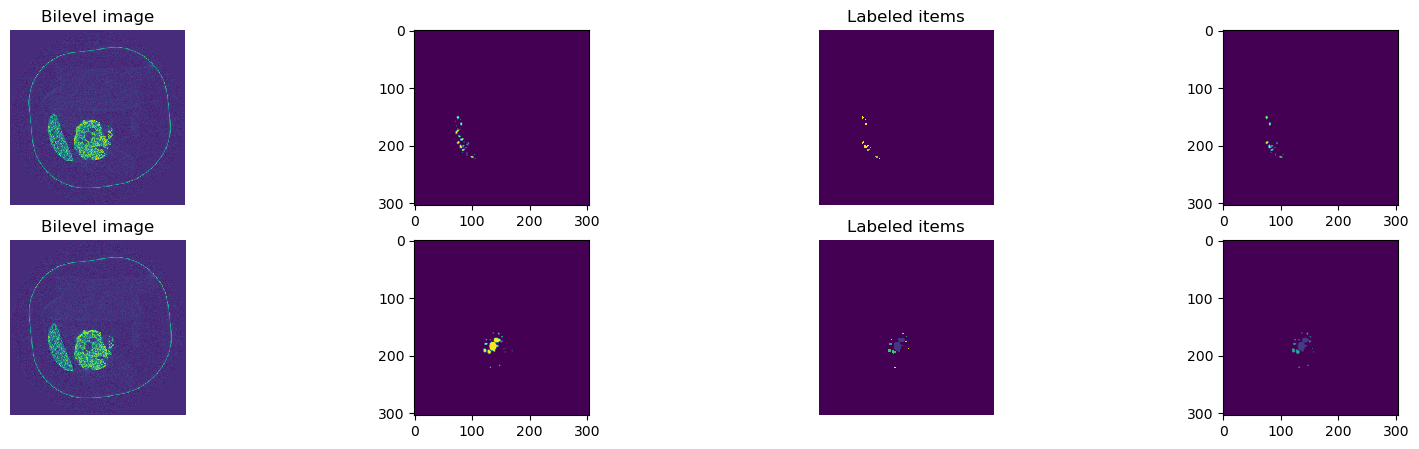

In [177]:
cur_img_sample = img_sample-60

fig,ax=plt.subplots(2,4,figsize=(20,5))

ax[0,0].imshow(downsample_img[cur_img_sample],interpolation='none'), ax[0,0].axis('off')
ax[0,0].set_title('Bilevel image');
temp_img = ax[0,2].imshow(lbl_1[cur_img_sample], interpolation='none'),ax[0,2].axis('off')
ax[0,2].set_title('Labeled items');
ax[0,1].imshow(inverted_image_1[cur_img_sample], cmap='viridis')
ax[0,3].imshow(merged_labelled_image_1[cur_img_sample], cmap='viridis')

ax[1,0].imshow(downsample_img[cur_img_sample],interpolation='none'), ax[1,0].axis('off')
ax[1,0].set_title('Bilevel image');
temp_img = ax[1,2].imshow(lbl_14[cur_img_sample], interpolation='none'),ax[1,2].axis('off')
ax[1,2].set_title('Labeled items');
ax[1,1].imshow(inverted_image_14[cur_img_sample], cmap='viridis')
ax[1,3].imshow(merged_labelled_image_14[cur_img_sample], cmap='viridis')

In [26]:
regions_1 = regionprops(merged_labelled_image_1)
regions_table_1 = regionprops_table(merged_labelled_image_1, properties=('centroid', 'area'))
regions_table_1 = pd.DataFrame(regions_table_1)

regions_14 = regionprops(merged_labelled_image_14)
regions_table_14 = regionprops_table(merged_labelled_image_14, properties=('centroid', 'area'))
regions_table_14 = pd.DataFrame(regions_table_14)


#for region in regions:
#    print(f"Pore label: {region.label}, Volume: {region.area}, Centroid: {region.centroid}")
print(regions_table_1)
print(regions_table_14)

      centroid-0  centroid-1  centroid-2   area
0       2.234201   21.912020  489.688352   1614
1       0.454545   15.545455  390.090909     11
2       2.438776   16.724490  391.897959     98
3       8.238147   49.911688  470.362636  17359
4      13.673274   40.553274  339.268673   2825
...          ...         ...         ...    ...
2198  254.600000  468.440000  261.200000     25
2199  254.533333  470.200000  257.400000     15
2200  254.454545  470.272727  259.272727     11
2201  254.454545  473.327273  169.472727     55
2202  254.467532  485.545455  341.415584     77

[2203 rows x 4 columns]
      centroid-0  centroid-1  centroid-2   area
0       2.879301   21.876733  490.172060   1947
1       1.272727   15.909091  390.500000     22
2       1.541667   16.875000  392.479167     48
3       8.839161   51.895462  468.798664  21705
4      10.188261   33.535433  423.248389   1397
...          ...         ...         ...    ...
1788  254.434783  374.869565  230.652174     23
1789  254.46511

In [83]:
merged_labelled_image_14.size

66846976

In [27]:
regions_full_1 = regionprops_table(label(filled_pores_1)[0], properties=('centroid', 'area'))
regions_full_1 = pd.DataFrame(regions_full_1)
regions_full_14 = regionprops_table(label(filled_pores_14)[0], properties=('centroid', 'area'))
regions_full_14 = pd.DataFrame(regions_full_14)

print(regions_full_1)
print(regions_full_14)

   centroid-0  centroid-1  centroid-2      area
0   99.838257  313.182703  322.157013  29186717
   centroid-0  centroid-1  centroid-2      area
0   99.821023  313.831738  322.308226  29434349


In [1]:
pore_volumes_1 = [region.area for region in regions_1]
pore_volumes_14 = [region.area for region in regions_14]
pore_lengths_1 = [max(region.bbox[3] - region.bbox[0], region.bbox[4] - region.bbox[1], region.bbox[5] - region.bbox[2]) for region in regions_1]
pore_lengths_14 = [max(region.bbox[3] - region.bbox[0], region.bbox[4] - region.bbox[1], region.bbox[5] - region.bbox[2]) for region in regions_14]

fig, ax = plt.subplots(1,2,figsize=(10,5))

# Plot the pore size distribution
ax[0].hist(pore_volumes_1, bins=151, density=True, range=(50,1000), edgecolor='blue', alpha=0.6)
ax[0].hist(pore_volumes_14, bins=151, density=True, range=(50,1000), edgecolor='orange', alpha=0.4)
ax[0].set_xlabel('Pore Volume')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pore Size Distribution')
#ax[0].legend(loc='upper right')

ax[1].hist(pore_lengths_1, bins=151, density=True, range=(0,100), edgecolor='blue', alpha=0.6)
ax[1].hist(pore_lengths_14, bins=151, density=True, range=(0,100), edgecolor='orange', alpha=0.4)
ax[1].set_xlabel('Pore Length')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pore Length Distribution')

NameError: name 'regions_1' is not defined

Text(0.5, 1.0, 'Pore Size Distribution')

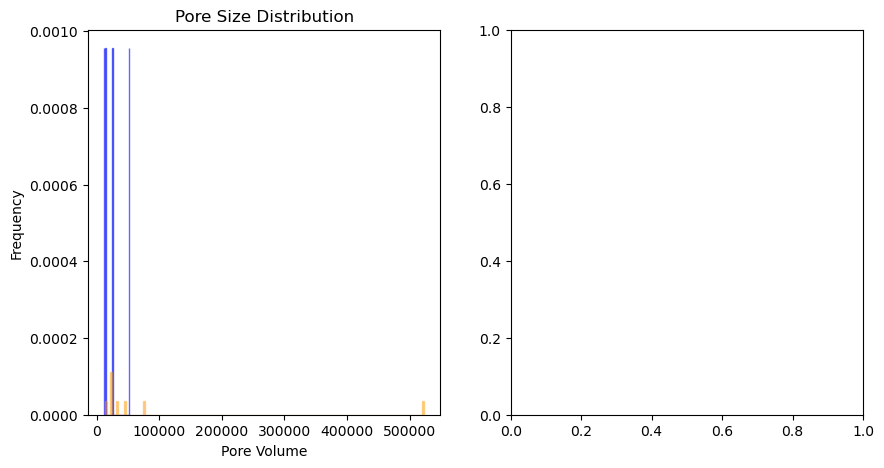

In [153]:
pore_volumes_large_1 = []
for region in regions_1:
    if region.area>10000:
        pore_volumes_large_1.append(region.area)
        
pore_volumes_large_14 = []
for region in regions_14:
    if region.area>10000:
        pore_volumes_large_14.append(region.area)
        
fig, ax = plt.subplots(1,2,figsize=(10,5))

# Plot the pore size distribution
ax[0].hist(pore_volumes_large_1, bins=151, density=True, edgecolor='blue', alpha=0.6)
ax[0].hist(pore_volumes_large_14, bins=151, density=True, edgecolor='orange', alpha=0.4)
ax[0].set_xlabel('Pore Volume')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pore Size Distribution')

In [47]:
size_merged_labelled_image_1 = merged_labelled_image_1[filled_pores_1].size
pores_merged_labelled_image_1 = np.sum((merged_labelled_image_1[filled_pores_1]>0))
print("Porosity 1 (%) = "+str(100*pores_merged_labelled_image_1/size_merged_labelled_image_1))

size_merged_labelled_image_14 = merged_labelled_image_14[filled_pores_14].size
pores_merged_labelled_image_14 = np.sum((merged_labelled_image_14[filled_pores_14]>0))
print("Porosity 14 (%) = "+str(100*pores_merged_labelled_image_14/size_merged_labelled_image_14))

Porosity 1 (%) = 12.73441956490002
Porosity 14 (%) = 13.60026342012864


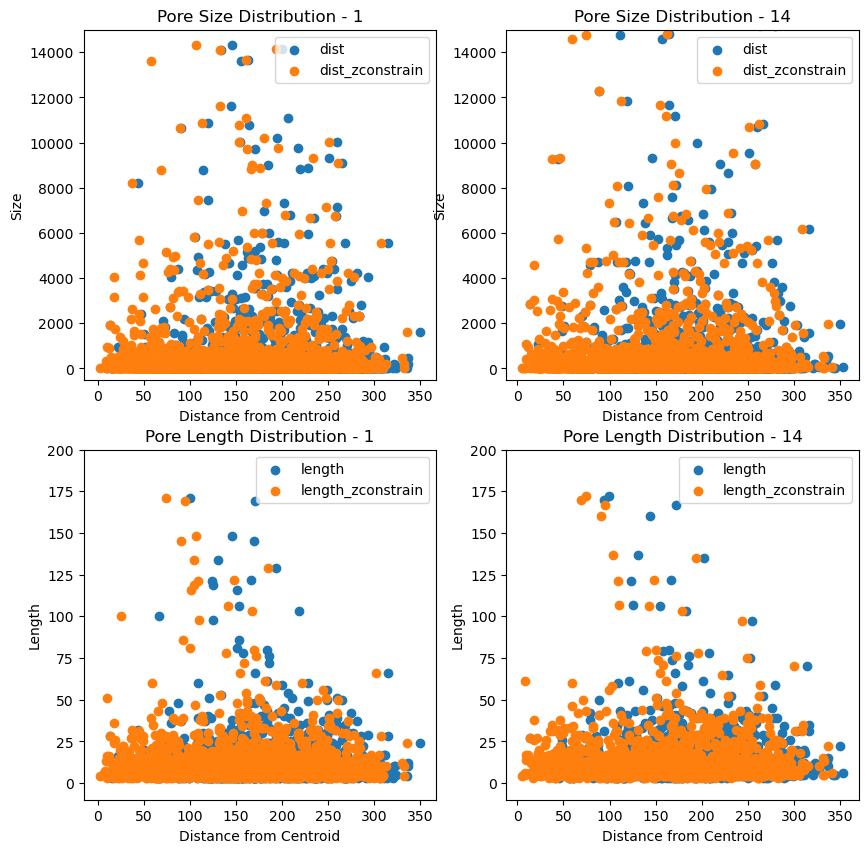

In [49]:
def compute_distance_from_centroid(regions_full, coord):
    return np.sqrt((regions_full["centroid-0"][0] - coord[0])**2 + (regions_full["centroid-1"][0] - coord[1])**2 + (regions_full["centroid-2"][0] - coord[2])**2)

def compute_distance_from_centroid_zconstrain(regions_full, coord):
    # Assumption - x and y coords of centroid are true for each slice
    return np.sqrt((regions_full["centroid-1"][0] - coord[1])**2 + (regions_full["centroid-2"][0] - coord[2])**2)

pore_distances_1 = [compute_distance_from_centroid(regions_full_1, region.centroid) for region in regions_1]
pore_distances_14 = [compute_distance_from_centroid(regions_full_14, region.centroid) for region in regions_14]

pore_distances_1_zconstrain = [compute_distance_from_centroid_zconstrain(regions_full_1, region.centroid) for region in regions_1]
pore_distances_14_zconstrain = [compute_distance_from_centroid_zconstrain(regions_full_14, region.centroid) for region in regions_14]

fig, ax = plt.subplots(2,2,figsize=(10,10))

# Plot the pore size distribution
ax[0,0].scatter(pore_distances_1, pore_volumes_1, label='dist')
ax[0,0].scatter(pore_distances_1_zconstrain, pore_volumes_1, label='dist_zconstrain')
ax[0,0].set_xlabel('Distance from Centroid')
ax[0,0].set_ylabel('Size')
ax[0,0].set_ylim(-500,15000)
ax[0,0].set_title('Pore Size Distribution - 1')
ax[0,0].legend(loc='upper right')

ax[0,1].scatter(pore_distances_14, pore_volumes_14, label='dist')
ax[0,1].scatter(pore_distances_14_zconstrain, pore_volumes_14, label='dist_zconstrain')
ax[0,1].set_xlabel('Distance from Centroid')
ax[0,1].set_ylabel('Size')
ax[0,1].set_ylim(-500,15000)
ax[0,1].set_title('Pore Size Distribution - 14')
ax[0,1].legend(loc='upper right')

ax[1,0].scatter(pore_distances_1, pore_lengths_1, label='length')
ax[1,0].scatter(pore_distances_1_zconstrain, pore_lengths_1, label='length_zconstrain')
ax[1,0].set_xlabel('Distance from Centroid')
ax[1,0].set_ylabel('Length')
ax[1,0].set_ylim(-10,200)
ax[1,0].set_title('Pore Length Distribution - 1')
ax[1,0].legend(loc='upper right')

ax[1,1].scatter(pore_distances_14, pore_lengths_14, label='length')
ax[1,1].scatter(pore_distances_14_zconstrain, pore_lengths_14, label='length_zconstrain')
ax[1,1].set_xlabel('Distance from Centroid')
ax[1,1].set_ylabel('Length')
ax[1,1].set_ylim(-10,200)
ax[1,1].set_title('Pore Length Distribution - 14')
ax[1,1].legend(loc='upper right')


In [220]:
regions_full_1[0].area

1039144

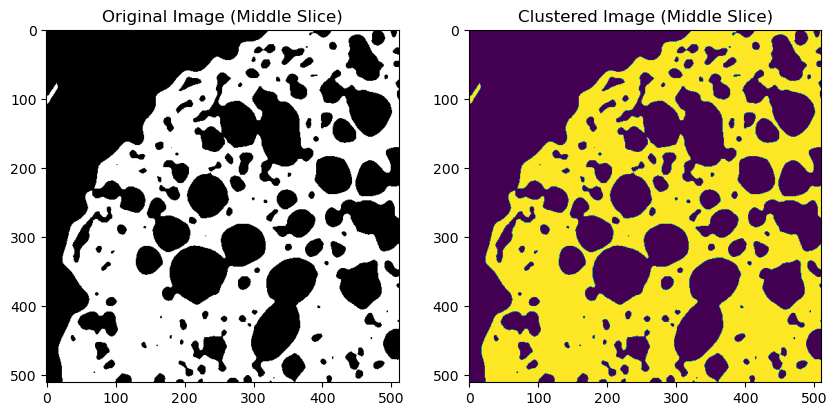

In [34]:
def perform_kmeans_clustering_3d(image_3d, n_clusters=3):
    """
    Perform K-means clustering on a 3D image.

    Parameters:
    image_3d (np.ndarray): 3D image array.
    n_clusters (int): Number of clusters.

    Returns:
    np.ndarray: 3D array with the same shape as image_3d, containing cluster labels.
    """
    # Reshape the 3D image into a 2D array (samples x features)
    depth, height, width = image_3d.shape
    image_2d = image_3d.reshape(-1, 1)  # Assuming grayscale image (1 feature)
    print(image_2d.shape)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(image_2d)
    labels_1d = kmeans.labels_

    # Reshape the 1D labels array back into the 3D image shape
    labels_3d = labels_1d.reshape(depth, height, width)
    print(labels_3d.shape)
    print(labels_3d.max())

    return labels_3d

#labels_3d = perform_kmeans_clustering_3d(medfilter3_ds_img*connthresh_medfilter3_ds_img, n_clusters=2)

cur_img_sample = img_sample
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(connthresh_medfilter3_ds_img[cur_img_sample], cmap='gray')
axes[0].set_title('Original Image (Middle Slice)')
axes[1].imshow(labels_3d[cur_img_sample]==1, cmap='viridis')
axes[1].set_title('Clustered Image (Middle Slice)')
plt.show()

In [ ]:
(connthresh_medfilter3_ds_img)

In [71]:
def analyze_pore_network_connectivity(binary_image_stack):
    """
    Analyze the pore network connectivity of a 3D binary image stack.
    """
    skeleton = skeletonize_3d(binary_image_stack)
    labeled_skeleton, num_features = label(skeleton)
    
    graph = nx.Graph()
    
    regions = regionprops(labeled_skeleton)
    
    for region in regions:
        coords = region.coords
        for coord in coords:
            graph.add_node(tuple(coord))
            for neighbor in get_neighbors(coord, labeled_skeleton.shape):
                if labeled_skeleton[neighbor] == region.label:
                    graph.add_edge(tuple(coord), neighbor)
    
    num_connected_components = nx.number_connected_components(graph)
    return num_connected_components, graph

#num_connected_components, pore_network_graph = analyze_pore_network_connectivity(inverted_image.astype(int))
num_connected_components, pore_network_graph = analyze_pore_network_connectivity(merged_labelled_image>0)
print(f"Number of Connected Components: {num_connected_components}")

Number of Connected Components: 18242


In [ ]:
nx.draw(pore_network_graph)

In [10]:
def montage_pad(x): return montage2d(
    np.pad(x, [(0, 0), (10, 10), (10, 10)], mode='constant', constant_values=0))

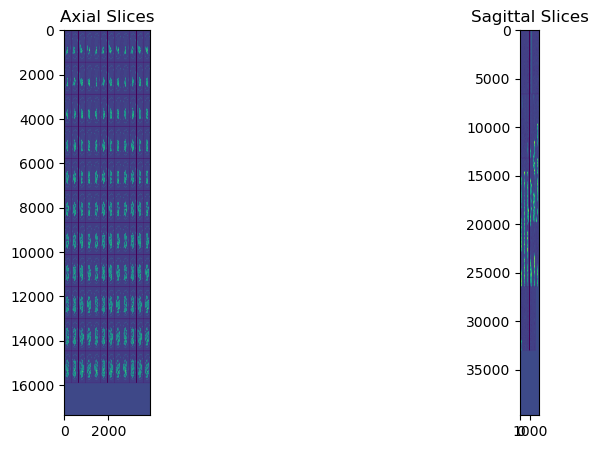

In [14]:
# Anisotropic data?

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(montage_pad(rescaled_image_stack[::50]));ax[0].set_title('Axial Slices')
ax[1].imshow(montage_pad(rescaled_image_stack.swapaxes(0, 1)[::50])); ax[1].set_title('Sagittal Slices');

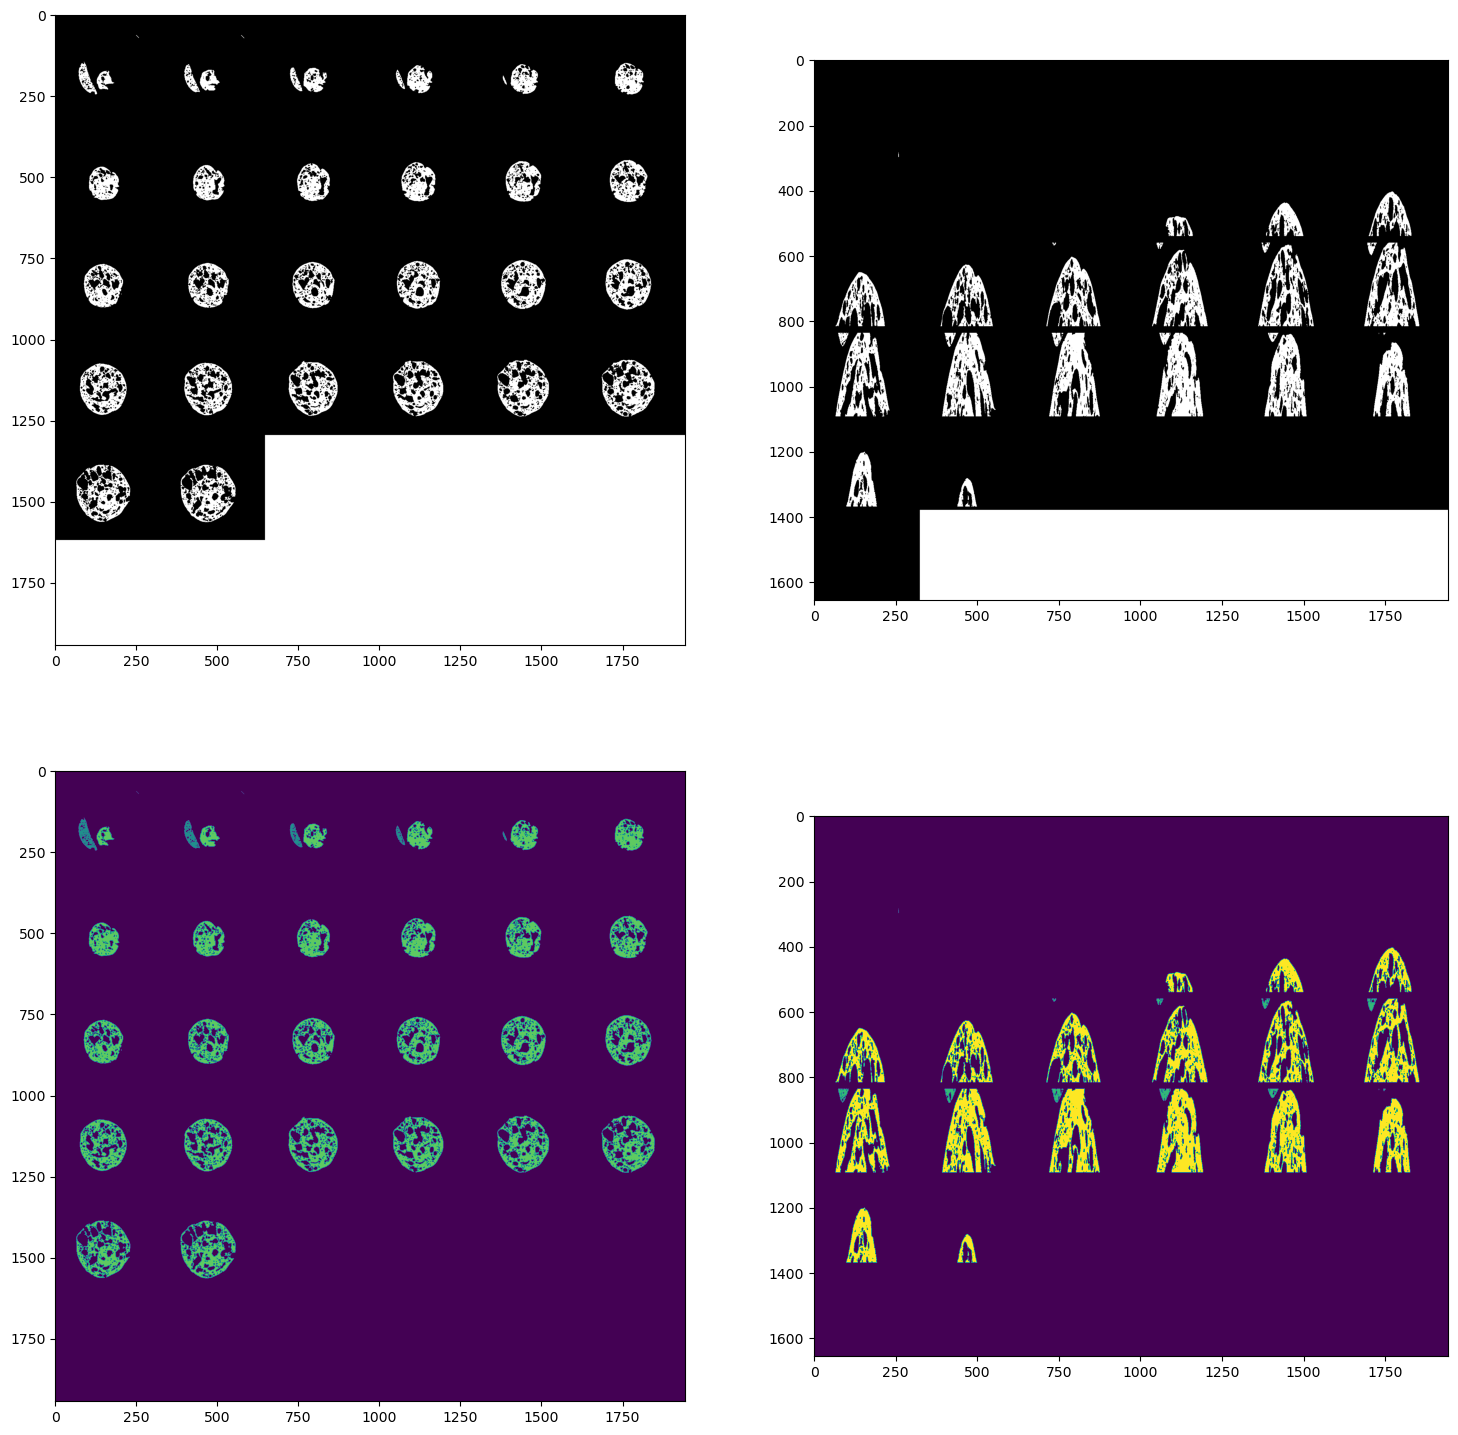

In [52]:
# Anisotropic data?

fig, ax = plt.subplots(2, 2, figsize=(18, 18))
ax[0,0].imshow(montage_pad(connthresh_medfilter3_ds_img[::10]), cmap='gray');ax1.set_title('Axial Slices')
ax[0,1].imshow(montage_pad(connthresh_medfilter3_ds_img.swapaxes(0, 1)[::10]), cmap='gray'); ax2.set_title('Sagittal Slices');
ax[1,0].imshow(montage_pad(lbl[::10]));ax1.set_title('Axial Slices')
ax[1,1].imshow(montage_pad(lbl.swapaxes(0, 1)[::10])); ax2.set_title('Sagittal Slices');

In [129]:
connthresh_medfilter3_ds_dist = distance_transform_edt(connthresh_medfilter3_ds_img)
inverted_image_dist = distance_transform_edt(inverted_image)

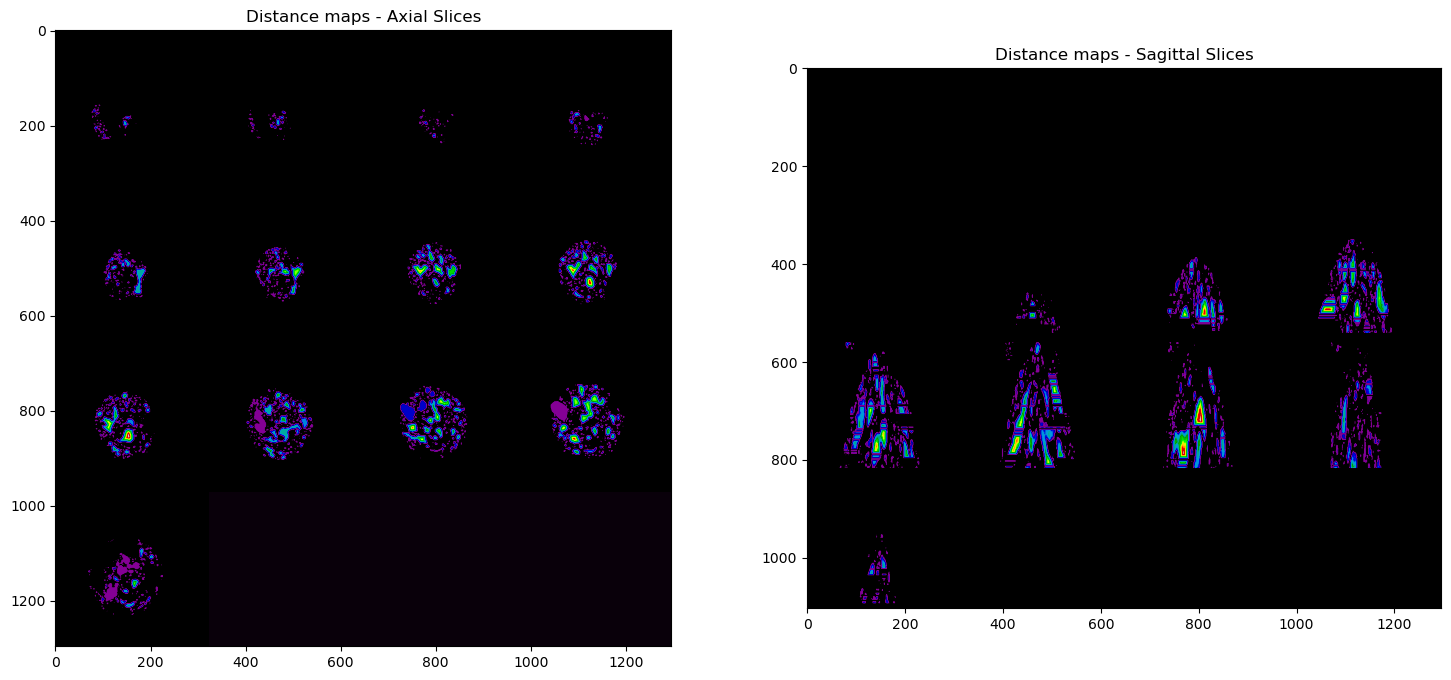

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.imshow(montage_pad(inverted_image_dist[::20]), cmap='nipy_spectral')
ax1.set_title('Distance maps - Axial Slices')
ax2.imshow(montage_pad(inverted_image_dist.swapaxes(0, 1)[::20]), cmap='nipy_spectral')
ax2.set_title('Distance maps - Sagittal Slices'); 

In [132]:
pore_candidates = peak_local_max(inverted_image_dist, min_distance=5)
print('Found', len(pore_candidates), 'bubbles')

thickness_map = np.zeros(inverted_image_dist.shape, dtype=np.float32)
xx, yy, zz = np.meshgrid(np.arange(inverted_image_dist.shape[1]),
                         np.arange(inverted_image_dist.shape[0]),
                         np.arange(inverted_image_dist.shape[2])
                         )
# sort candidates by size
sorted_candidates = sorted(
    pore_candidates, key=lambda xyz: inverted_image_dist[tuple(xyz)])
for label_idx, (x, y, z) in enumerate(sorted_candidates):
    cur_pore_radius = inverted_image_dist[x, y, z]
    cur_pore = ((xx-float(y))**2 +
                  (yy-float(x))**2 +
                  (zz-float(z))**2) <= cur_pore_radius**2
    thickness_map[cur_pore] = cur_pore_radius

Found 1584 bubbles


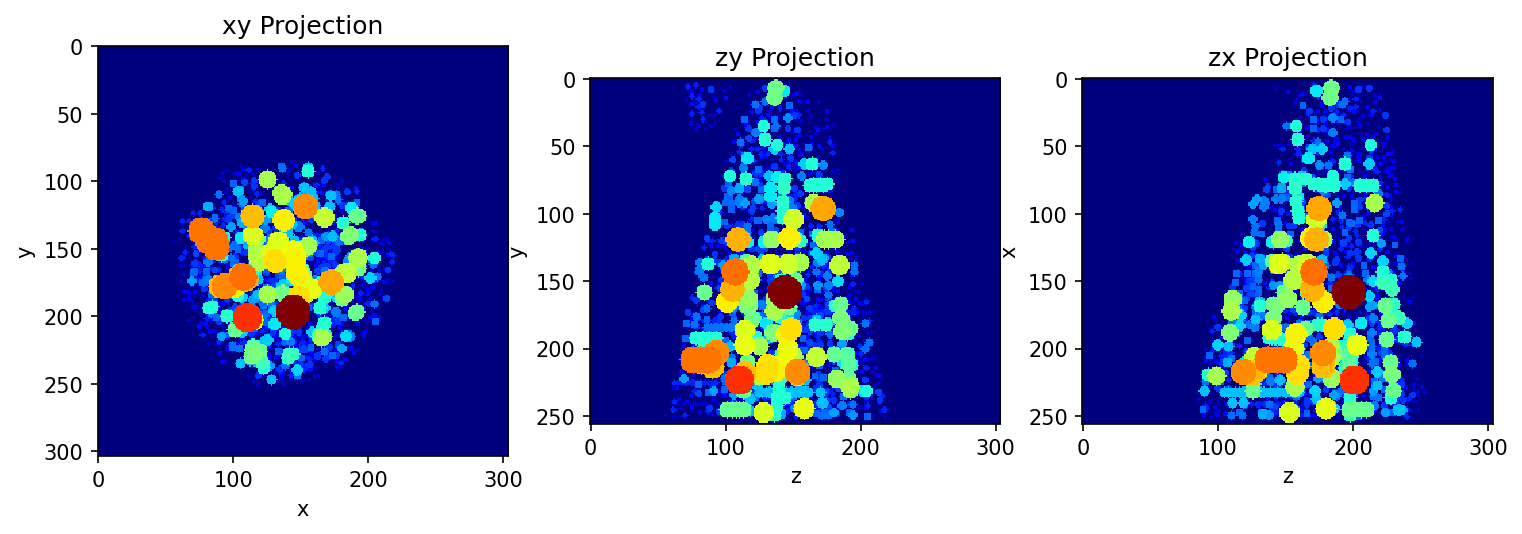

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
for i, (cax, clabel) in enumerate(zip([ax1, ax2, ax3], ['xy', 'zy', 'zx'])):
    cax.imshow(np.max(thickness_map, i).squeeze(),
               interpolation='none', cmap='jet')
    cax.set(title='{} Projection'.format(clabel), xlabel=clabel[0], ylabel=clabel[1]);

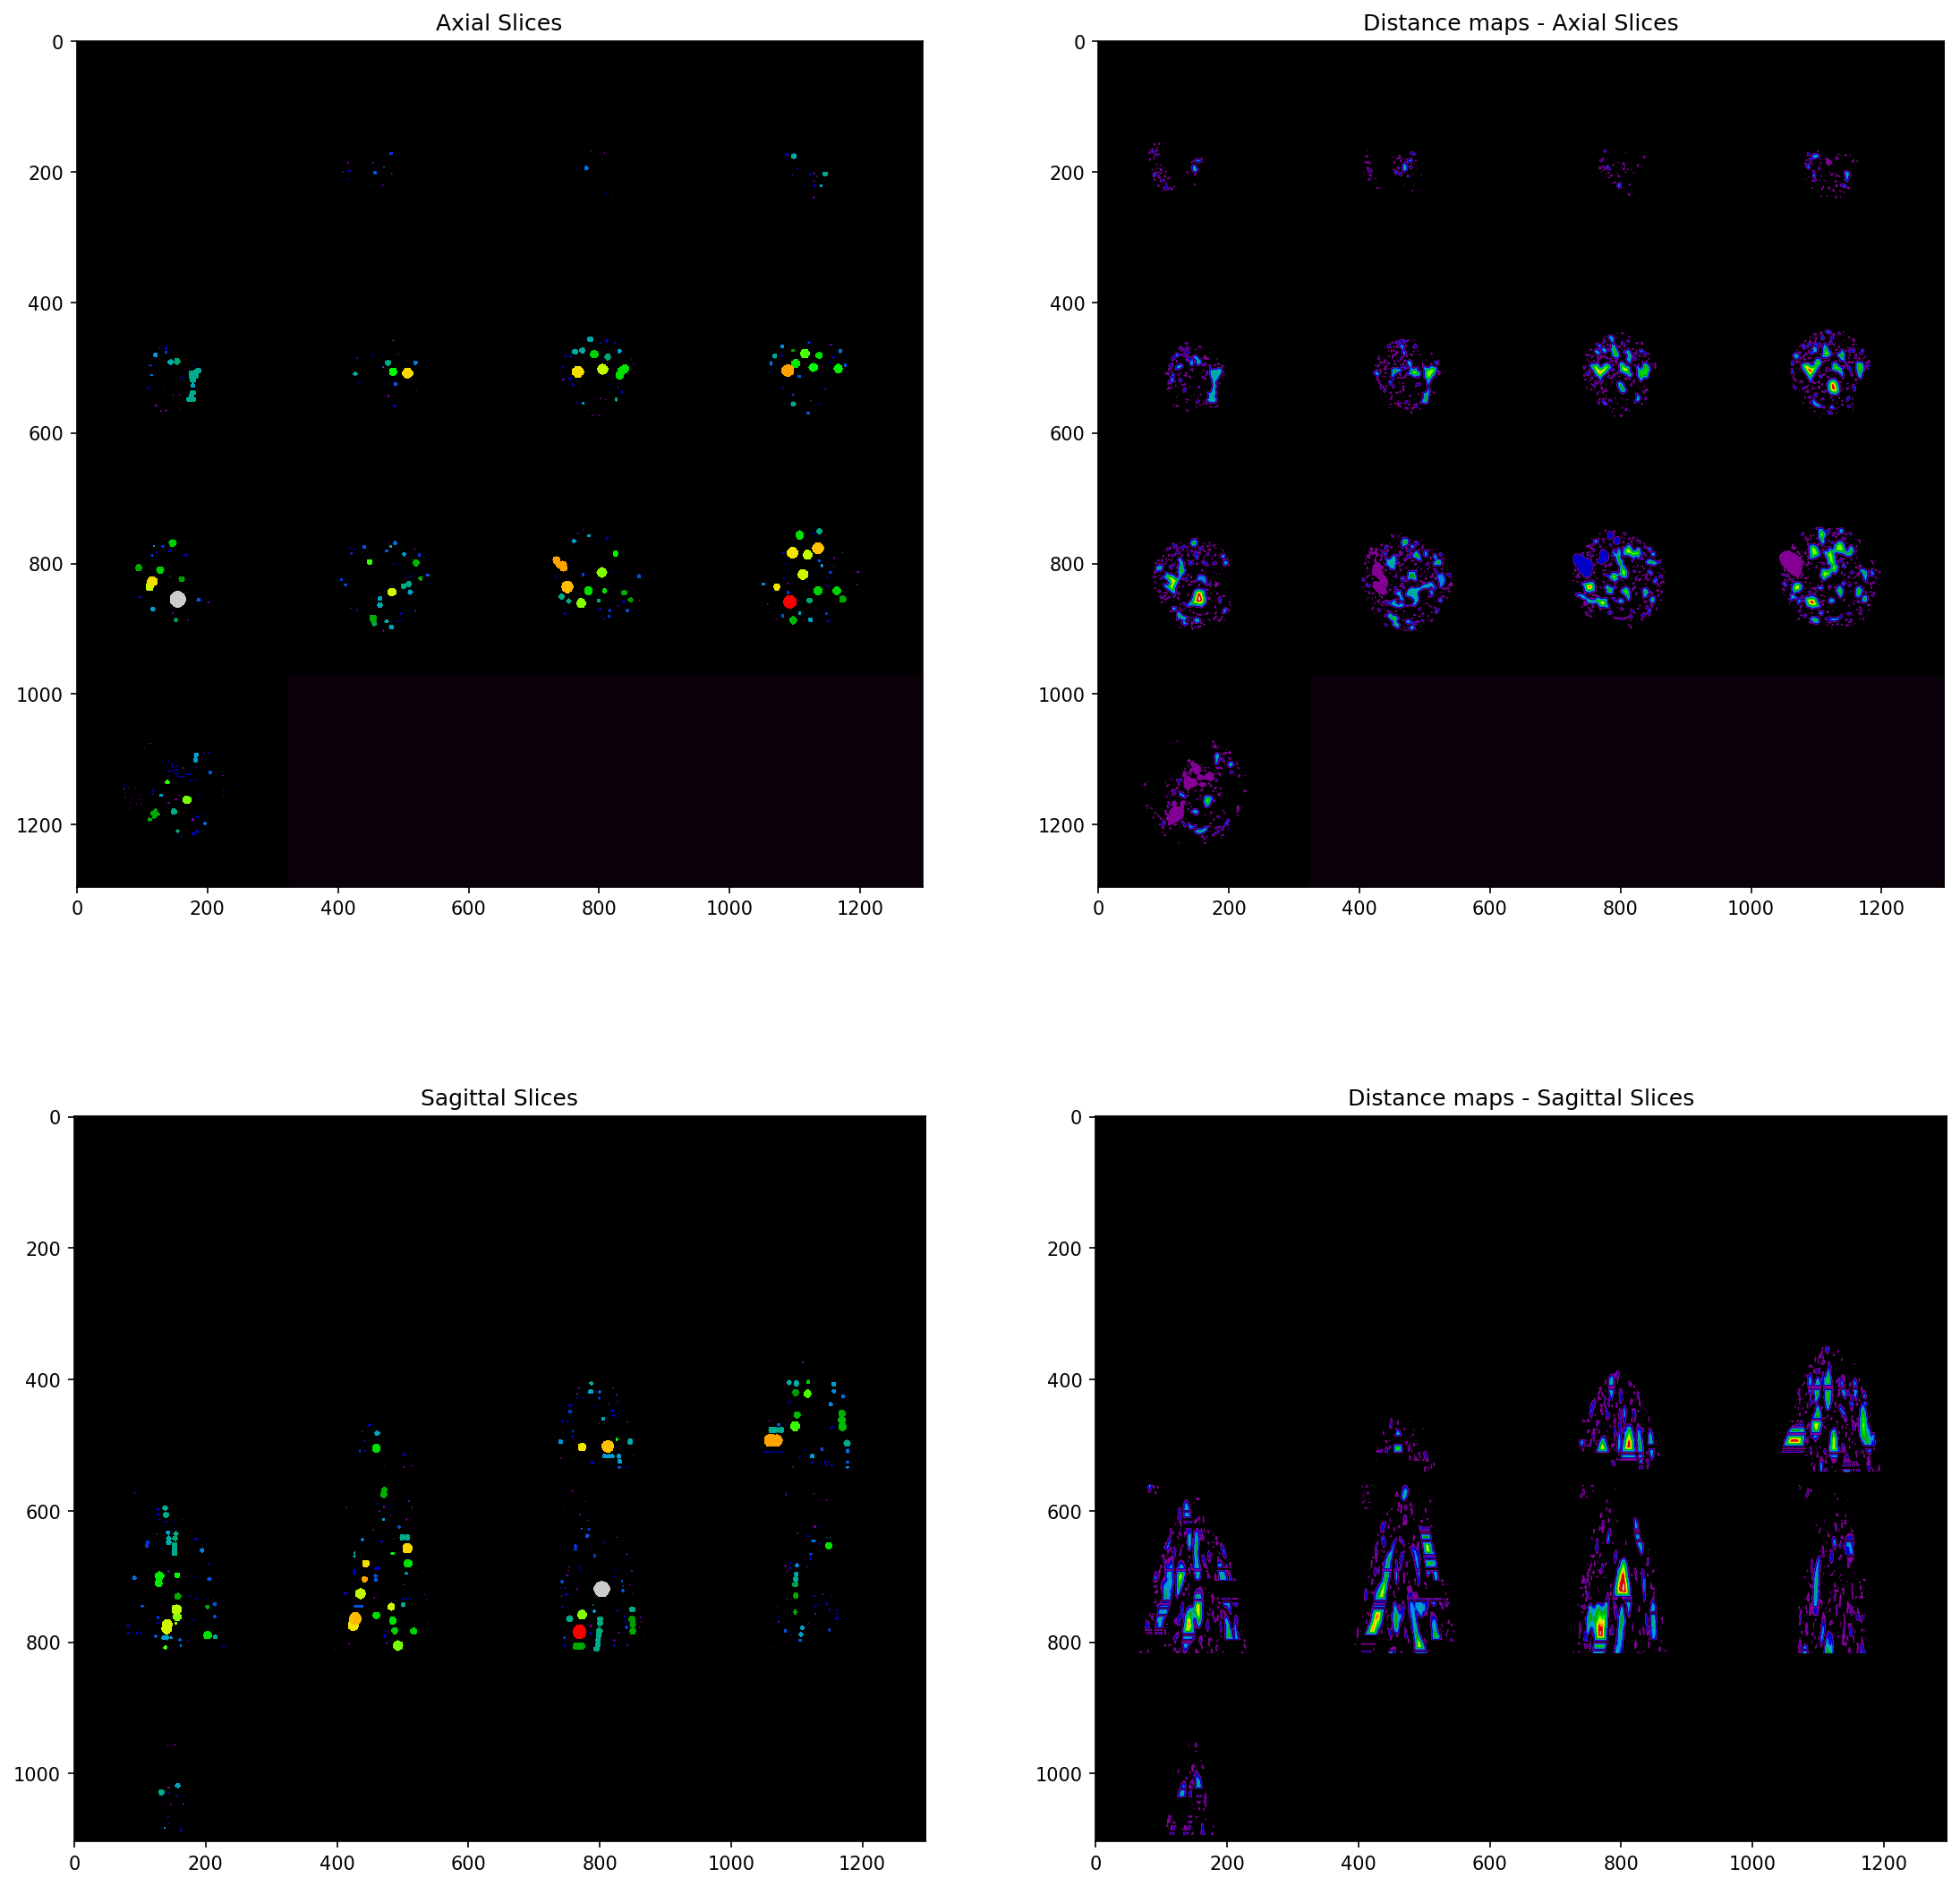

In [134]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18),dpi=150)
ax[0,0].imshow(montage_pad(thickness_map[::20]), cmap='nipy_spectral',interpolation="None")
ax[0,0].set_title('Axial Slices')
ax[1,0].imshow(montage_pad(thickness_map.swapaxes(
    0, 1)[::20]), cmap='nipy_spectral',interpolation="None")
ax[1,0].set_title('Sagittal Slices');
ax[0,1].imshow(montage_pad(inverted_image_dist[::20]), cmap='nipy_spectral')
ax[0,1].set_title('Distance maps - Axial Slices')
ax[1,1].imshow(montage_pad(inverted_image_dist.swapaxes(0, 1)[::20]), cmap='nipy_spectral')
ax[1,1].set_title('Distance maps - Sagittal Slices');

In [ ]:
# Porespy

  0%|          | 0/25 [00:00<?, ?it/s]

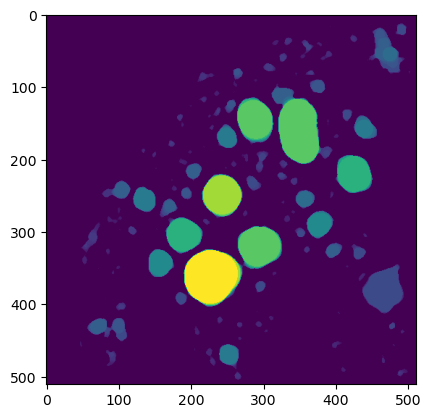

In [28]:
lt_14 = ps.filters.local_thickness(merged_labelled_image_14)
plt.imshow(lt_14[img_sample])

  0%|          | 0/25 [00:00<?, ?it/s]

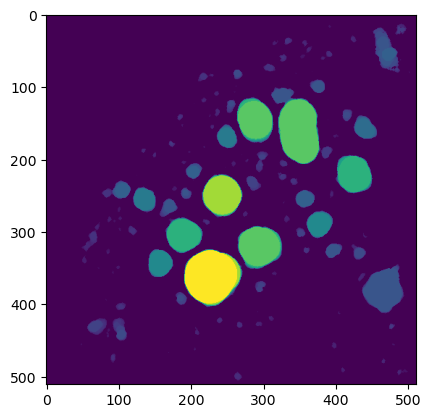

In [31]:
lt_1 = ps.filters.local_thickness(merged_labelled_image_1)
plt.imshow(lt_1[img_sample])

3.0980603405409567e-05


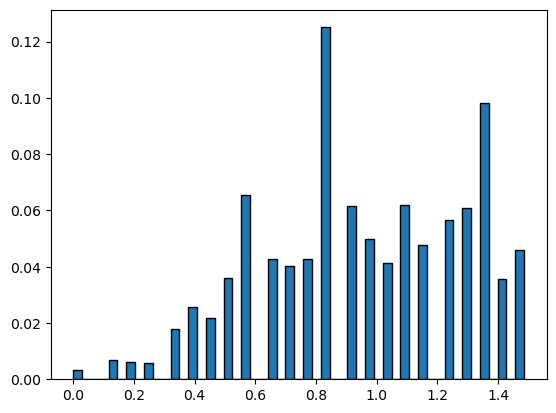

In [42]:
psd_14 = ps.metrics.pore_size_distribution(lt_14, bins=51, log=True)
plt.bar(psd_14.LogR, psd_14.satn, width=psd_14.bin_widths, edgecolor='k')
print(ps.metrics.porosity(merged_labelled_image_14))

In [30]:
regions_ps_14 = ps.metrics.regionprops_3D(merged_labelled_image_14)
#df_regions_ps_14 = ps.metrics.props_to_DataFrame(regions_ps_14)

In [32]:
regions_ps_1 = ps.metrics.regionprops_3D(merged_labelled_image_1)

In [33]:
pore_volume_ps_1 = [region.volume for region in regions_ps_1]
pore_volume_ps_14 = [region.volume for region in regions_ps_14]
pore_surface_area_ps_1 = [region.surface_area for region in regions_ps_1]
pore_surface_area_ps_14 = [region.surface_area for region in regions_ps_14]

Text(0.5, 1.0, 'Pore Surface Area Distribution')

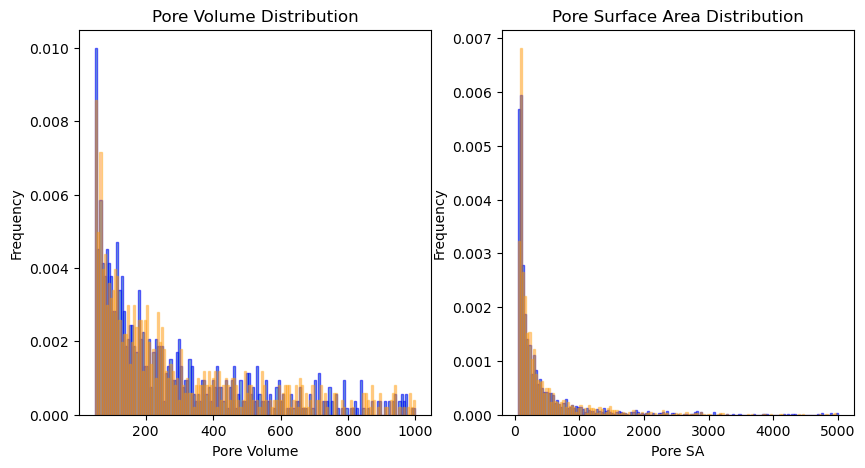

In [38]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

# Plot the pore size distribution
ax[0].hist(pore_volume_ps_1, bins=151, density=True, range=(50,1000), edgecolor='blue', alpha=0.6)
ax[0].hist(pore_volume_ps_14, bins=151, density=True, range=(50,1000), edgecolor='orange', alpha=0.4)
ax[0].set_xlabel('Pore Volume')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pore Volume Distribution')

# Plot the pore size distribution
ax[1].hist(pore_surface_area_ps_1, bins=151, density=True, range=(50,5000), edgecolor='blue', alpha=0.6)
ax[1].hist(pore_surface_area_ps_14, bins=151, density=True, range=(50,5000), edgecolor='orange', alpha=0.4)
ax[1].set_xlabel('Pore SA')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pore Surface Area Distribution')

In [ ]:
for i, region in enumerate(regions_ps_14):
    try:
        if region.convex_volume < 3:
            print("smaller than 3: "+str(region.label))
    except:
        print(i, region.label)
        regions_ps_14[i].convex_volume = regions_ps_14[i-1].convex_volume

In [ ]:
pore_net_14 = ps.network.regions_to_network(merged_labelled_image_14)

Text(0.5, 1.0, 'snow')

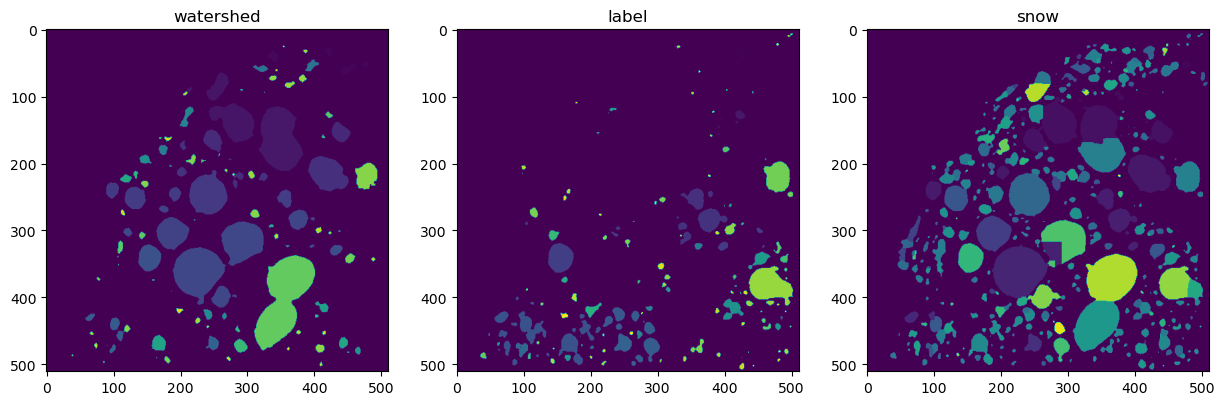

In [40]:
#snow_labelled_image_14 = ps.filters.snow_partitioning(inverted_image_14)

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].imshow(watershed_fg_14[cur_img_sample], cmap='viridis'); ax[0].set_title('watershed')
ax[1].imshow(lbl_14[cur_img_sample], cmap='viridis'); ax[1].set_title('label')
ax[2].imshow((snow_labelled_image_14.regions)[cur_img_sample], cmap='viridis'); ax[2].set_title('snow')